Here, we analyze within-host genetic diversity and evolutionary dynamics of H3N2 virus samples. 

# Import libraries

In [1]:
from os.path import expanduser
from importlib.machinery import SourceFileLoader

import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D 
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr, mannwhitneyu
import numpy as np

import pandas as pd 
import re
import random
import os

# load custom flu and ngs libraries 
laeb_lib = expanduser("../python_lib") # folder where custom libraries are saved 
fc = SourceFileLoader('fc', "%s/flu_common.py"%(laeb_lib)).load_module()
ngs = SourceFileLoader('ngs', "%s/laeb_ngs_pipeline.py"%(laeb_lib)).load_module()

# Inputs 

In [2]:
# inputs 
# file path to data folder - fastq files to be analysed must be in {data folder}/raw
data_folder = './data' 
# reference fasta file name (should be placed in input_folder)
ref_fasta_fname = './input/H3N2_Bris07.fasta' 
# CSV file containing the CDR regions of each gene segment (numbering should be based on that of the given reference sequence)
cds_coords = "./input/CDS_H3N2_Bris07.csv"
# primer coordinates (sequence numbering must be based on given reference sequence)
primer_coords = "./input/H3N2_primer_coords.csv"
# file path to metadata file. 
meta_fname = './results/metadata_wo_mixed_infections.csv' 

# mapping options
threadnum = 4 # number of CPU threads for parallelization 
base_qual_threshold = 20 # minimum accepted base quality 

# variant calling options
Query_HAnum_subtype = 'absH3' # query HA numbering subtype (i.e. numbering based on CDR HA protein )
HAnum_subtype = 'H3' # reporting HA numbering subtype
subtype_ant = 'H3ant'  # HA canonical antigenic site of interest 
min_cov = 100 # minimum coverage 
min_var_freq = 0 
min_var_prop = 0.02 # minimum variant proportion 
err_tol = 0.01 # threshold to which variant called could result from base calling error 
min_breadth = 0.7 # min breadth of gene segment to be mapped for further analysis 

# Parameters and functions 

This cell perform several initialisation procedures, including: 
 - defining parameters needed by the pipeline (e.g. gene segment length, etc.) and initialise to get CDR regions of each protein.
 - defining dataframe for HA numbering conversion

In [3]:
# presets 
reffasta = ref_fasta_fname

# initialise
gene_to_proteinorf, influenza_gene_len, sorted_refnames, nucpos_shift = ngs.initialisation(cds_coords, reffasta, laeb_lib)
display (gene_to_proteinorf.head())

ha_numbering_conversion = pd.read_csv(expanduser('%s/HA_numbering_conversion.csv'%(laeb_lib)),
                                      na_values='-')
ha_numbering_conversion = ha_numbering_conversion.set_index(Query_HAnum_subtype)
display (ha_numbering_conversion.head())

codon_table = {
            'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
            'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
            'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
            'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
            'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',}
all_bases = ['A', 'T', 'G', 'C']


Initialising CDS coordinates...

Check translated protein sequences...
PB2 MERIKELRNLMSQSRTREILTKTTVDHMAIIKKYTSGRQEKNPSLRMKWMMAMKYPITADKRITEMVPERNEQGQTLWSKMSDAGSDRVMVSPLAVTWWNRNGPVTSTVHYPKVYKTYFDKVERLKHGTFGPVHFRNQVKIRRRVDINPGHADLSAKEAQDVIMEVVFPNEVGARILTSESQLTITKEKKEELRDCKISPLMVAYMLERELVRKTRFLPVAGGTSSIYIEVLHLTQGTCWEQMYTPGGGVRNDDVDQSLIIAARNIVRRAAVSADPLASLLEMCHSTQIGGTRMVDILRQNPTEEQAVDICKAAMGLRISSSFSFGGFTFKRTSGSSVKKEEEVLTGNLQTLKIRVHEGYEEFTMVGKRATAILRKATRRLVQLIVSGRDEQSIAEAIIVAMVFSQEDCMIKAVRGDLNFVNRANQRLNPMHQLLRHFQKDAKVLFQNWGVEHIDSVMGMIGVLPDMTPSTEMSMRGIRVSKMGVDEYSSTERVVVSIDRFLRVRDQRGNVLLSPEEVSETQGTERLTITYSSSMMWEINGPESVLVNTYQWIIRNWEAVKIQWSQNPAMLYNKMEFEPFQSLVPKAIRSQYSGFVRTLFQQMRDVLGTFDTTQIIKLLPFAAAPPKQSRMQFSSLTVNVRGSGMRILVRGNSPVFNYNKTTKRLTILGKDAGTLIEDPDESTSGVESAVLRGFLIIGKEDRRYGPALSINELSNLAKGEKANVLIGQGDVVLVMKRKRDSSILTDSQTATKRIRMAIN*
PB1 MDVNPTLLFIKVPAQNAISTTFPYTGDPPYSHGTGTGYTMDTVNRTHQYSEKGKWTTNTETGAPQLNPIDGPLPEDNEPSGYAQTDCVLEAMAFLEESHPGIFENSCLETMEAVQQTRVDKLTQGRQTYDWTLNRNQPAATALANTIEVFRSNGLTANE

aa  frame
gene  nuc protein           
1-PB2 1   PB2       1      1
      2   PB2       1      2
      3   PB2       1      3
      4   PB2       2      1
      5   PB2       2      2

,H3,absH1pdm,absH5,H1N1pdm,H5,H5c221,H1ant,H3ant,RBS
absH3,,,,,,,,,
1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0
2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,0
3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,0
4.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,0
5.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,0


## Read metadata (after removing samples with likely mixed infections) and variant calling files

In [4]:
# metadata 
## metadata must have 'sampid' header which is used as sample identifier 
meta_df = pd.read_csv('%s'%meta_fname)
sorted_sampid = sorted(set(meta_df['sampid']))

meta_df = meta_df.set_index("sampid")
display (meta_df.head())

# vcf 
variant_call_df = pd.read_csv("./results/variant_call_MinCoV%i_MinProp%.2f_MinFreq%i_ErrTol%.2f.csv"%(min_cov, min_var_prop, min_var_freq, err_tol))
variant_call_df['protein'] = variant_call_df['protein'].fillna("NA")
variant_call_df = variant_call_df.set_index(["sampid", 'gene'])
display (variant_call_df.head())

,subject_id,enrolD,idx,ct,SampleType,aliquot,run,primer_i5,primer_i7,enrol-onset,...,timepoint,patch,1-PB2,2-PB1,3-PA,4-HA,5-NP,6-NA,7-M,8-NS
sampid,,,,,,,,,,,,,,,,,,,,,
H3N2_1205_T0_T_S517_N701_R,1205,0,R1,26,T,1,1,S517,N701,6.0,...,6.0,0,1.0,1.0,0.962963,1.000000,1.000000,0.844828,1.0,0.945946
H3N2_1205_T1_N_S517_N702_R,1205,1,R2,25,N,1,1,S517,N702,6.0,...,7.0,0,1.0,1.0,1.000000,1.000000,1.000000,0.931034,1.0,1.000000
H3N2_1205_T2_T_S517_N703_R,1205,2,R3,30,T,1,1,S517,N703,6.0,...,8.0,0,1.0,1.0,0.907407,0.985294,0.866667,0.844828,1.0,1.000000
H3N2_1205_T3_T_S517_N704_R,1205,3,R4,29,T,1,1,S517,N704,6.0,...,9.0,0,1.0,1.0,0.962963,1.000000,0.966667,0.844828,1.0,1.000000
H3N2_1205_T4_T_S517_N705_R,1205,4,R5,28,T,1,1,S517,N705,6.0,...,10.0,0,1.0,1.0,0.962963,1.000000,1.000000,0.844828,1.0,1.000000


nucpos nuc_var  nuc_prop  nuc_freq  \
sampid                     gene                                        
H3N2_1205_T0_T_S517_N701_R 1-PB2    1221       A  0.080098       293   
                           4-HA      939       G  0.073570       265   
                           4-HA     1275       C  0.044221        88   
                           5-NP     1058       T  0.032740       125   
                           5-NP     1150       A  0.123601       276   

                                 nuc_consensus  nuc_consensus_freq  \
sampid                     gene                                      
H3N2_1205_T0_T_S517_N701_R 1-PB2             G                3358   
                           4-HA              A                3336   
                           4-HA              T                1902   
                           5-NP              C                3689   
                           5-NP              G                1955   

                                  nuc_coverage protein  aapos HA_num_type  \
sampid                     gene                                             
H3N2_1205_T0_T_S517_N701_R 1-PB2          3658     PB2    407         NaN   
                           4-HA           3602      HA    297          H3   
                           4-HA           1990      HA    409          H3   
                           5-NP           3818      NP    353         NaN   
                           5-NP           2233      NP    384         NaN   

                                 aa_var   aa_prop  aa_freq  \
sampid                     gene                              
H3N2_1205_T0_T_S517_N701_R 1-PB2      E  0.082117    287.0   
                           4-HA       V  0.074179    262.0   
                           4-HA       L  0.042916     83.0   
                           5-NP       F  0.033270    122.0   
                           5-NP       R  0.124709    268.0   

                                 expected_aa_consensus aa_consensus  \
sampid                     gene                                       
H3N2_1205_T0_T_S517_N701_R 1-PB2                     E            E   
                           4-HA                      V            V   
                           4-HA                      L            L   
                           5-NP                      S            S   
                           5-NP                      G            G   

                                  aa_consensus_freq  aa_coverage  codon_pos  \
sampid                     gene                                               
H3N2_1205_T0_T_S517_N701_R 1-PB2             3196.0       3495.0          3   
                           4-HA              3267.0       3532.0          3   
                           4-HA              1839.0       1934.0          3   
                           5-NP              3531.0       3667.0          2   
                           5-NP              1871.0       2149.0          1   

                                 codon  nonsyn  
sampid                     gene                 
H3N2_1205_T0_T_S517_N701_R 1-PB2   GAA     0.0  
                           4-HA    GTG     0.0  
                           4-HA    CTC     0.0  
                           5-NP    TTT     1.0  
                           5-NP    AGG     1.0

# Plot cycle threshold (CT) values against time

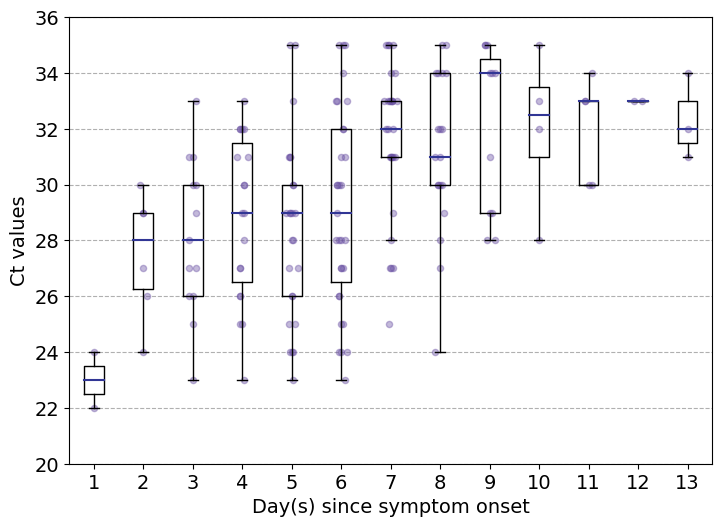

SpearmanrResult(correlation=0.4681598595405035, pvalue=1.3775682468985077e-10)
pearsonr (0.4513627458191385, 7.319729312086095e-10)


In [10]:
def get_jitter_xvals(data, center_x, width, bins=20):
    
    counts, edges = np.histogram(data, bins=bins)

    centres = (edges[:-1] + edges[1:]) / 2.
    yvals = centres.repeat(counts)

    max_offset = width / counts.max()
    offsets = np.hstack(list((np.arange(cc) - 0.5 * (cc - 1)) for cc in counts))
    
    return center_x + (offsets * max_offset)

# reset meta_df index  
try:
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index('timepoint').sort_index()

x_values = []
y_values = []
for timepoint in sorted(set(meta_df.index.get_level_values(0))): 
    # only analyse samples with information of time since symptom onset 
    if pd.isna(timepoint): 
        continue 
    
    tp_meta_df = meta_df.loc[timepoint].copy()
    
    # filter samples where WG > min_breadth
    if isinstance(tp_meta_df, pd.Series):
        tp_meta_df = tp_meta_df.to_frame().T
    tp_meta_df = tp_meta_df[(tp_meta_df[sorted_refnames]>min_breadth).all(axis=1)]
    
    if len(tp_meta_df) == 0: 
        continue
    
    x_values.append(int(timepoint))
    y_values.append(list(tp_meta_df['ct']))
    
# plot boxplots
with plt.style.context('default'):
    fig, ax = plt.subplots(1, 1, figsize=(8.3, 5.8))
    ax.boxplot(y_values, positions=np.array(range(len(x_values))), sym='', widths=0.4, 
               medianprops=dict(linewidth=1.5, color='#313695'))

    # plot actual data as jitter 
    for idx, yval in enumerate(y_values):
        try: 
            ax.scatter(get_jitter_xvals(yval, center_x=idx,  width=0.3), 
                       yval, s=20, c='#6a51a3', alpha=.4)
        except:  
            ax.scatter([idx*2-0.4]*len(yval),
                       yval, s=20, c='#6a51a3', alpha=.4)

    # set x-ticks 
    ax.set_xticks(range(0, len(x_values)))
    ax.set_xticklabels(map(int, x_values))

    # set y-ticks 
    #ax.set_ylim((-1, 130))

    # grid lines 
    ax.grid(axis='y', ls='--', zorder=0)
    ax.set_axisbelow(True)

    # remove left and right spines 
    """ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)"""


    # tick fontsize
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel('Day(s) since symptom onset', fontsize=14)
    ax.set_ylabel('Ct values', fontsize=14)
    ax.set_ylim((20, 36))

    plt.savefig('./results/figures/CT_v_DaysSinceSymptomOnset.pdf',
                bbox_inches='tight', pad_inches=0.05)
    plt.show()

# pearson R 
all_x_values = []
all_y_values = []
for xidx, xval in enumerate(x_values): 
    all_x_values += [xval]*len(y_values[xidx])
    all_y_values += y_values[xidx]
    
print (spearmanr(all_x_values, all_y_values))
print ("pearsonr", pearsonr(all_x_values, all_y_values))

# Plot number of minority iSNVs against time/CT values 

'timepoint'

SpearmanrResult(correlation=0.46200135985392476, pvalue=2.5683176590829527e-10)

'pearsonr'

(0.40517212083744936, 4.646784241951002e-08)

'ct'

SpearmanrResult(correlation=0.5070875039529481, pvalue=1.2623648343550028e-12)

'pearsonr'

(0.5034346331061649, 1.9371807349764792e-12)

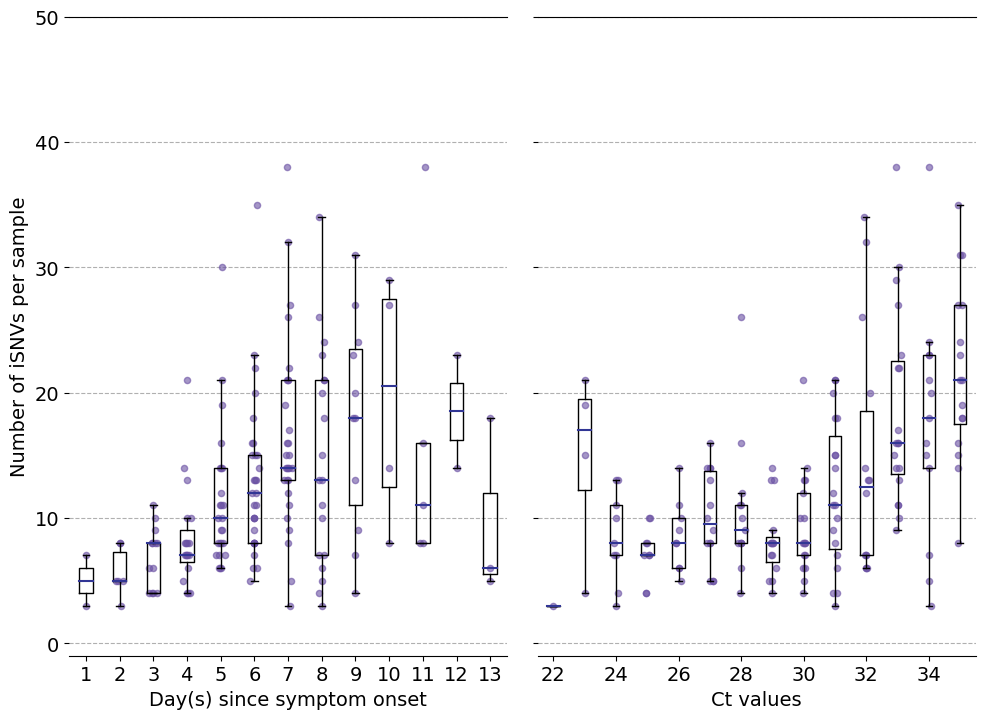

In [12]:
def get_jitter_xvals(data, center_x, width, bins=20):
    
    counts, edges = np.histogram(data, bins=bins)

    centres = (edges[:-1] + edges[1:]) / 2.
    yvals = centres.repeat(counts)

    max_offset = width / counts.max()
    offsets = np.hstack(list((np.arange(cc) - 0.5 * (cc - 1)) for cc in counts))
    
    return center_x + (offsets * max_offset)

try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 
variant_call_df = variant_call_df.set_index('sampid')

with plt.style.context('default'):
    fig, axes = plt.subplots(1, 2, figsize=(11.7, 8.3), sharey=True)

    for xidx, x_variable in enumerate(['timepoint', 'ct']): 
        ax = axes[xidx]

        # reset meta_df index  
        try:
            meta_df = meta_df.reset_index()
        except: 
            pass 
        meta_df = meta_df.set_index([x_variable, 'sampid']).sort_index()

        x_values = []
        iSNVdist_yvals = []

        for x_var in sorted(set(meta_df.index.get_level_values(0))): 
            # only analyse samples with information of time since symptom onset / ct value
            if pd.isna(x_var): 
                continue 

            tp_meta_df = meta_df.loc[x_var]

            # must satisfy min_breadth for all gene segments 
            tp_sampids = list(tp_meta_df[(tp_meta_df[sorted_refnames]>min_breadth).all(axis=1)].index)

            # no samples satisfying min_breadth 
            if len(tp_sampids) == 0:
                continue 

            # get number of iSNV across entire genome for each sampid 
            curr_x_var_iSNVdist = []
            for sampid in tp_sampids:

                try: 
                    sample_vcf = variant_call_df.loc[sampid].copy().reset_index()
                except: 
                    curr_x_var_iSNVdist.append(0)
                    continue 

                #sample_vcf = sample_vcf[sample_vcf['nuc_prop']>min_prop]

                # only consider nucleotide variants 
                sample_vcf = sample_vcf.drop_duplicates(['gene', 'nucpos', 'nuc_var'])

                sample_vcf = sample_vcf.drop_duplicates(subset=['gene', 'nucpos', 'nuc_var'])
                sample_vcf = sample_vcf[sample_vcf['nuc_prop']<.5]

                curr_x_var_iSNVdist.append(len(sample_vcf))
                #print (sampid, len(sample_vcf))

            iSNVdist_yvals.append (curr_x_var_iSNVdist)
            x_values.append(x_var)

        # plot boxplots
        ax.boxplot(iSNVdist_yvals, positions=np.array(range(len(iSNVdist_yvals))), sym='', widths=0.4, 
                   medianprops=dict(linewidth=1.5, color='#313695'))

        # plot actual data as jitter 
        for idx, yval in enumerate(iSNVdist_yvals):
            try: 
                ax.scatter(get_jitter_xvals(yval, center_x=idx,  width=0.3), 
                           yval, s=20, c='#6a51a3', alpha=.6)
            except:  
                ax.scatter([idx*2-0.4]*len(yval),
                           yval, s=20, c='#6a51a3', alpha=.6)

        # set y-ticks 
        ax.set_ylim((-1, 50))

        # grid lines 
        ax.grid(axis='y', ls='--', zorder=0)
        ax.set_axisbelow(True)

        # tick fontsize
        ax.tick_params(axis='both', which='major', labelsize=14)
        if x_variable == 'ct': 
            ax.set_xlabel('Ct values', fontsize=14)
            # set x-ticks 
            ax.set_xticks(range(0, len(x_values), 2))
            ax.set_xticklabels(map(int, [x for _x, x in enumerate(x_values) if _x%2==0]))
        else: 
            ax.set_xlabel('Day(s) since symptom onset', fontsize=14)
            # set x-ticks 
            ax.set_xticks(range(0, len(x_values)))
            ax.set_xticklabels(map(int, x_values))

        if xidx == 0: 
            ax.set_ylabel('Number of iSNVs per sample', fontsize=14)

        # remove left and right spines 
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # spearman rho
        all_x_values = []
        all_y_values = []
        for xidx, xval in enumerate(x_values): 
            all_x_values += [xval]*len(iSNVdist_yvals[xidx])
            all_y_values += iSNVdist_yvals[xidx]

        #print (all_x_values)
        #print (all_y_values)
        display (x_variable, spearmanr(all_x_values, all_y_values))
        display ('pearsonr', pearsonr(all_x_values, all_y_values))

    plt.subplots_adjust(wspace = 0.07, hspace = 0.2)
    plt.savefig('./results/figures/iSNVcounts_v_DaysSinceSymptomOnset_and_CT.pdf', 
                bbox_inches='tight', pad_inches=0.)
    plt.show()

# Compute nucleotide diversity ($\pi$)

In [13]:
def compute_pi(allele_array, L):
    N = allele_array.sum(axis=1)
    den = N*(N-1)
    num = den - (allele_array*(allele_array-1)).sum(axis=1)
    return (num/den).sum()/L

try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 

if os.path.isfile("./results/nucleotide_diversity_df.csv"): 
    nucleotide_diversity_df = pd.read_csv("./results/nucleotide_diversity_df.csv")
else: 
    print ("Computing nucleotide diversity...")
    nucleotide_diversity_df = []
    variant_call_df = variant_call_df.set_index(["sampid", "gene"])
    for (sampid, gene) in set(variant_call_df.index): 
        sample_gene_vcf = variant_call_df.loc[(sampid, gene)].copy()
        sample_gene_vcf = sample_gene_vcf.drop_duplicates(["nucpos", "nuc_var"])
        if len(sample_gene_vcf) > 1: 
            sample_gene_vcf = sample_gene_vcf.reset_index().set_index(['nucpos'])

            all_allele_counts = []
            for nucpos in set(sample_gene_vcf.index): 
                nucpos_sample_gene_vcf = sample_gene_vcf.loc[nucpos]
                if isinstance(nucpos_sample_gene_vcf, pd.Series):
                    nucpos_sample_gene_vcf = nucpos_sample_gene_vcf.to_frame().T

                nucpos_sample_gene_vcf = nucpos_sample_gene_vcf.set_index("nuc_var")

                allele_counts = []
                for idx, nuc_var in enumerate(nucpos_sample_gene_vcf.index):
                    # get consensus count 
                    if idx == 0:
                        allele_counts.append(nucpos_sample_gene_vcf.loc[nuc_var, "nuc_consensus_freq"])
                    # add individual variant
                    allele_counts.append(nucpos_sample_gene_vcf.loc[nuc_var, "nuc_freq"])
                all_allele_counts.append(allele_counts)

            arr_len = list(map(len, all_allele_counts))
            if len(set(arr_len)) > 1: 
                # make all arrays of the same dim
                max_len = max(arr_len)
                for idx, allele_counts in enumerate(all_allele_counts): 
                    if len(allele_counts) != max_len:
                        all_allele_counts[idx] += [0]*(max_len-len(allele_counts))

            pi = compute_pi(np.array(all_allele_counts), influenza_gene_len[gene])
            nucleotide_diversity_df.append({"sampid":sampid, "gene":gene, "pi":pi})

    nucleotide_diversity_df = pd.DataFrame.from_dict(nucleotide_diversity_df)
    nucleotide_diversity_df.to_csv("./results/nucleotide_diversity_df.csv", index=False)

nucleotide_diversity_df = nucleotide_diversity_df.set_index("sampid")
display (nucleotide_diversity_df.head())

,gene,pi
sampid,,
H3N2_1671_T0_T_S506_N707_R,3-PA,0.000130
H3N2_1843_T2_N_S504_N712_R,5-NP,0.000215
H3N2_1828_T1_N_S503_N709_R,4-HA,0.000222
H3N2_1412_T0_N_S503_N712_R,6-NA,0.000114
H3N2_1864_T2_T_S506_N710_R,4-HA,0.000193


'timepoint'

SpearmanrResult(correlation=0.41750974196148033, pvalue=1.6287969302765462e-08)

pearsonr (0.38779203978291565, 1.8967227070737848e-07)


'ct'

SpearmanrResult(correlation=0.4548431344506882, pvalue=3.653577684249376e-10)

pearsonr (0.4708510856462441, 7.115395234770545e-11)


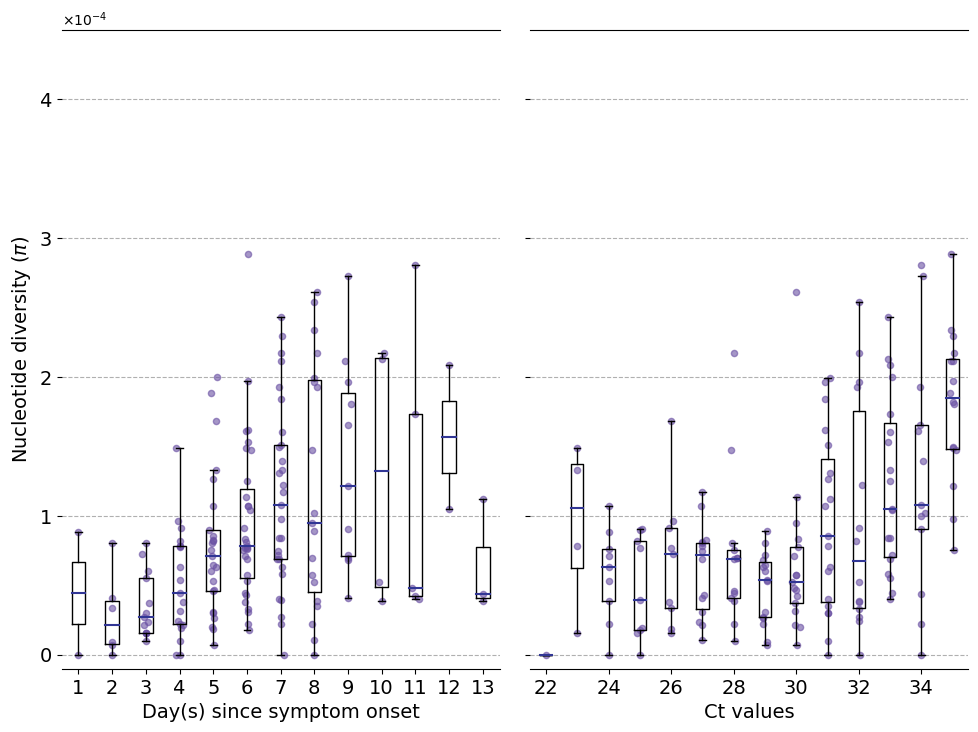

In [14]:
all_sample_wise_pi = []

with plt.style.context('default'):
    fig, axes = plt.subplots(1, 2, figsize=(11.7, 8.3), sharey=True)

    for xidx, x_variable in enumerate(['timepoint', 'ct']): 

        ax = axes[xidx]

        # reset meta_df index  
        try:
            meta_df = meta_df.reset_index()
        except: 
            pass 
        meta_df = meta_df.set_index([x_variable, 'sampid']).sort_index()

        y_values = []
        x_values = []

        for x_var in sorted(set(meta_df.index.get_level_values(0))): 
            if pd.isna(x_var): 
                continue

            tp_meta_df = meta_df.loc[x_var].copy()

            # get all samples where all segments > min_breadth 
            sampid_list = list(tp_meta_df[(tp_meta_df[sorted_refnames]>min_breadth).all(axis=1)].index)
            if len(sampid_list) == 0: 
                continue 

            x_values.append(x_var)

            # get shannon entropy dataframe - na values == Shannon=0
            curr_x_yvals = []
            for sampid in sampid_list: 
                try:
                    sampid_nucleotide_diversity_df = nucleotide_diversity_df.loc[sampid]
                except: 
                    curr_x_yvals.append(0.)
                    continue
                if isinstance(sampid_nucleotide_diversity_df, pd.Series): 
                    sampid_nucleotide_diversity_df = sampid_nucleotide_diversity_df.to_frame().T
                sampid_pi = sampid_nucleotide_diversity_df['pi'].to_numpy()
                coef = np.array([influenza_gene_len[gene]/sum(influenza_gene_len.values()) for gene in sampid_nucleotide_diversity_df['gene']])
                curr_x_yvals.append((sampid_pi*coef).sum())
            y_values.append(curr_x_yvals)
            if xidx == 0: 
                all_sample_wise_pi += curr_x_yvals

        # plot boxplots
        ax.boxplot(y_values, positions=np.array(range(len(y_values))), 
                   sym='', widths=0.4, 
                   medianprops=dict(linewidth=1.5, color='#313695'))

        # plot actual data as jitter 
        for idx, yval in enumerate(y_values):
            try: 
                ax.scatter(get_jitter_xvals(yval, center_x=idx,  width=0.3), 
                           yval, s=20, c='#6a51a3', alpha=.6)
            except:  
                ax.scatter([idx*2-0.4]*len(yval),
                           yval, s=20, c='#6a51a3', alpha=.6)

        # set y-ticks 
        ax.set_ylim((-0.1e-4, 4.5e-4))

        # grid lines 
        ax.grid(axis='y', ls='--', zorder=0)
        ax.set_axisbelow(True)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)

        # tick fontsize
        ax.tick_params(axis='both', which='major', labelsize=14)
        if x_variable == 'ct': 
            ax.set_xlabel('Ct values', fontsize=14)
            # set x-ticks 
            ax.set_xticks(range(0, len(x_values), 2))
            ax.set_xticklabels(map(int, [x for _x, x in enumerate(x_values) if _x%2==0]))
            
        else: 
            ax.set_xlabel('Day(s) since symptom onset', fontsize=14)
            # set x-ticks 
            ax.set_xticks(range(0, len(x_values)))
            ax.set_xticklabels(map(int, x_values))

        if xidx == 0: 
            ax.set_ylabel('Nucleotide diversity $(\pi)$', fontsize=14)

        # remove left and right spines 
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # pearson R 
        all_x_values = []
        all_y_values = []
        for xidx, xval in enumerate(x_values): 
            all_x_values += [xval]*len(y_values[xidx])
            all_y_values += y_values[xidx]

        display (x_variable, spearmanr(all_x_values, all_y_values))
        print ("pearsonr", pearsonr(all_x_values, all_y_values))

    plt.subplots_adjust(wspace = 0.07, hspace = 0.2)
    plt.savefig('./results/figures/pi_v_DaysSinceSymptomOnset_and_CT.pdf',
                bbox_inches='tight', pad_inches=0.)

    plt.show()
    
#print (all_sample_wise_pi)

# iSNV histogram

,Synonymous,Nonsynonymous,Stop
Frequency,,,
0.05,4.424419,4.308140,0.343023
0.10,1.744966,1.496644,0.154362
0.15,1.032609,0.695652,0.010870
0.20,0.950000,0.450000,0.000000
0.25,0.833333,0.452381,0.023810


Overall NS/S = 0.722


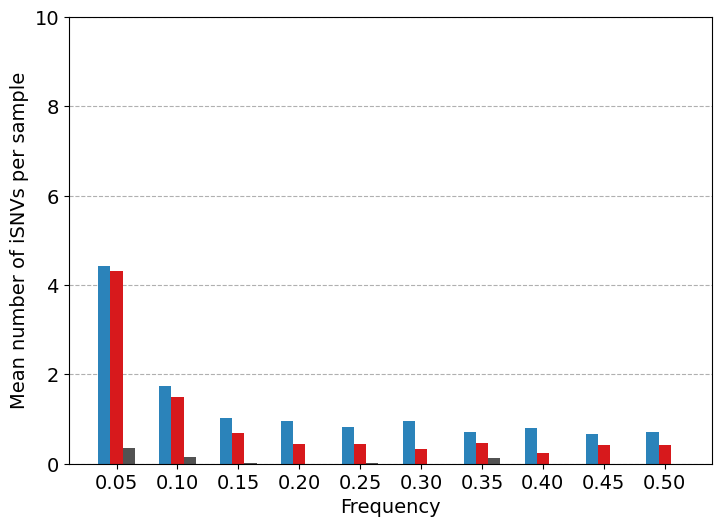

In [15]:
try: 
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index('sampid').sort_index()

try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 
variant_call_df = variant_call_df.set_index(['sampid', 'gene', 'nucpos', 'nuc_var']).sort_index()

with plt.style.context('default'):
    fig, ax = plt.subplots(1, 1, figsize=(8.3, 5.8))

    freq_to_count = {}
    bins = np.arange(0.05, 1.05, 0.05)

    for freq in bins: 
        freq_vcf = variant_call_df[(variant_call_df['nuc_prop']<freq)&(variant_call_df['nuc_prop']>=freq-0.05)].copy()

        # filter sampids where all gene segments fulfill min_breadth requirement 
        sampid_list = list(set(freq_vcf.index.get_level_values(0)))
        sampid_list = list(set(sampid_list)&set(meta_df.index))
        sampid_list = list(meta_df.loc[sampid_list][(meta_df.loc[sampid_list][sorted_refnames]>min_breadth).all(axis=1)].index)
        freq_vcf = freq_vcf[freq_vcf.index.get_level_values(0).isin(sampid_list)]

        if len(freq_vcf) == 0: 
            # do something
            continue 

        # separate into synonymous and nonsynonymous substitutions 
        nonsyn_count = 0
        syn_count = 0
        stop_count = 0

        for idx in freq_vcf.index: 
            # nucleotide mutation leads to either syn or nonsyn sub for any protein gene encodes
            if isinstance(freq_vcf.loc[idx], pd.Series) == True:
                if freq_vcf.loc[idx, 'nonsyn'] < 0:
                    stop_count += 1
                elif freq_vcf.loc[idx, 'nonsyn'] > 0:
                    nonsyn_count += 1
                else: 
                    syn_count += 1
            else: 
                if len(freq_vcf.loc[idx]) == 1 or len(set(freq_vcf.loc[idx, 'nonsyn'])) == 1: 
                    if freq_vcf.loc[idx, 'nonsyn'].iloc[0] < 0: 
                        stop_count += 1
                    elif freq_vcf.loc[idx, 'nonsyn'].iloc[0] > 0: 
                        nonsyn_count += 1
                    else: 
                        syn_count += 1
                else: 
                    # for each protein that the gene encodes 
                    idx_freq_vcf = freq_vcf.loc[idx]
                    for protein in set(idx_freq_vcf['protein']): 
                        protein_idx_freq_vcf = idx_freq_vcf[idx_freq_vcf['protein']==protein]

                        # nucleotide mutation leads to either syn or nonsyn sub for protein 
                        if len(protein_idx_freq_vcf) == 1: 
                            if freq_vcf.loc[idx, 'nonsyn'].iloc[0] < 0: 
                                stop_count += 1
                            elif freq_vcf.loc[idx, 'nonsyn'].iloc[0] > 0: 
                                nonsyn_count += 1
                            else: 
                                syn_count += 1
                        else: 
                            # nucleotide mutation leads to both syn and nonsyn sub
                            display (protein_idx_freq_vcf)
                            # continue if not enough aa_consensus 
                            if protein_idx_freq_vcf['aa_coverage'].iloc[0]<min_cov: 
                                continue 
                            else: 
                                nonsyn_prop = protein_idx_freq_vcf[protein_idx_freq_vcf['nonsyn']>0]['aa_prop'].sum()
                                syn_prop = protein_idx_freq_vcf[protein_idx_freq_vcf['nonsyn']<1.]['aa_prop'].sum()
                                #! -- need to fix this -- #
                            continue 

        total_num_of_samples = len(set(freq_vcf.index.get_level_values(0)))

        rounded_freq = np.around(freq, 2)
        if rounded_freq > 0.5: 
            continue 
        try:
            freq_to_count[rounded_freq]["Synonymous"] += syn_count/total_num_of_samples
            freq_to_count[rounded_freq]["Nonsynonymous"] += nonsyn_count/total_num_of_samples
            freq_to_count[rounded_freq]["Stop"] += stop_count/total_num_of_samples
        except: 
            freq_to_count[rounded_freq] = {"Synonymous":syn_count/total_num_of_samples, 
                                           "Nonsynonymous":nonsyn_count/total_num_of_samples, 
                                           "Stop":stop_count/total_num_of_samples}

    overall_iSNVfreq_distributions = []
    for freq, count_dict in freq_to_count.items(): 
        row = {"Frequency":freq}
        for k, v in count_dict.items():
            row[k] = v
        overall_iSNVfreq_distributions.append(row)

    overall_iSNVfreq_distributions = pd.DataFrame.from_dict(overall_iSNVfreq_distributions)
    overall_iSNVfreq_distributions = overall_iSNVfreq_distributions.set_index("Frequency")
    display (overall_iSNVfreq_distributions.head())
    print ("Overall NS/S = %.3f"%(overall_iSNVfreq_distributions['Nonsynonymous'].sum()/overall_iSNVfreq_distributions['Synonymous'].sum()))

    #overall_iSNVfreq_distributions.plot.bar(ax=ax, fontsize=12, color=['#2b83ba', '#d7191c'], )

    labels = list(overall_iSNVfreq_distributions.index)

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    ax.bar(x - width, overall_iSNVfreq_distributions['Synonymous'], width, label='Synonymous', color="#2b83ba")
    ax.bar(x, overall_iSNVfreq_distributions['Nonsynonymous'], width, label='Nonsynonymous', color="#d7191c")
    ax.bar(x + width, overall_iSNVfreq_distributions['Stop'], width, label='Stop', color="#525252")

    # grid lines 
    ax.grid(axis='y', ls='--', zorder=0)
    ax.set_axisbelow(True)

    # labels
    ax.set_xlabel("Frequency", fontsize=14)
    ax.set_ylabel("Mean number of iSNVs per sample", fontsize=14)

    ax.set_xticks(x)
    ax.set_xticklabels(["%.2f"%(l) for l in labels])
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    ax.tick_params(which='both', labelsize=14)

    ax.set_ylim(0, 10)
    #ax.legend()

    # y-axis label 
    plt.savefig('./results/figures/syn_nonsyn_histogram_overall.pdf',
                bbox_inches='tight', pad_inches=0.)
    plt.show()

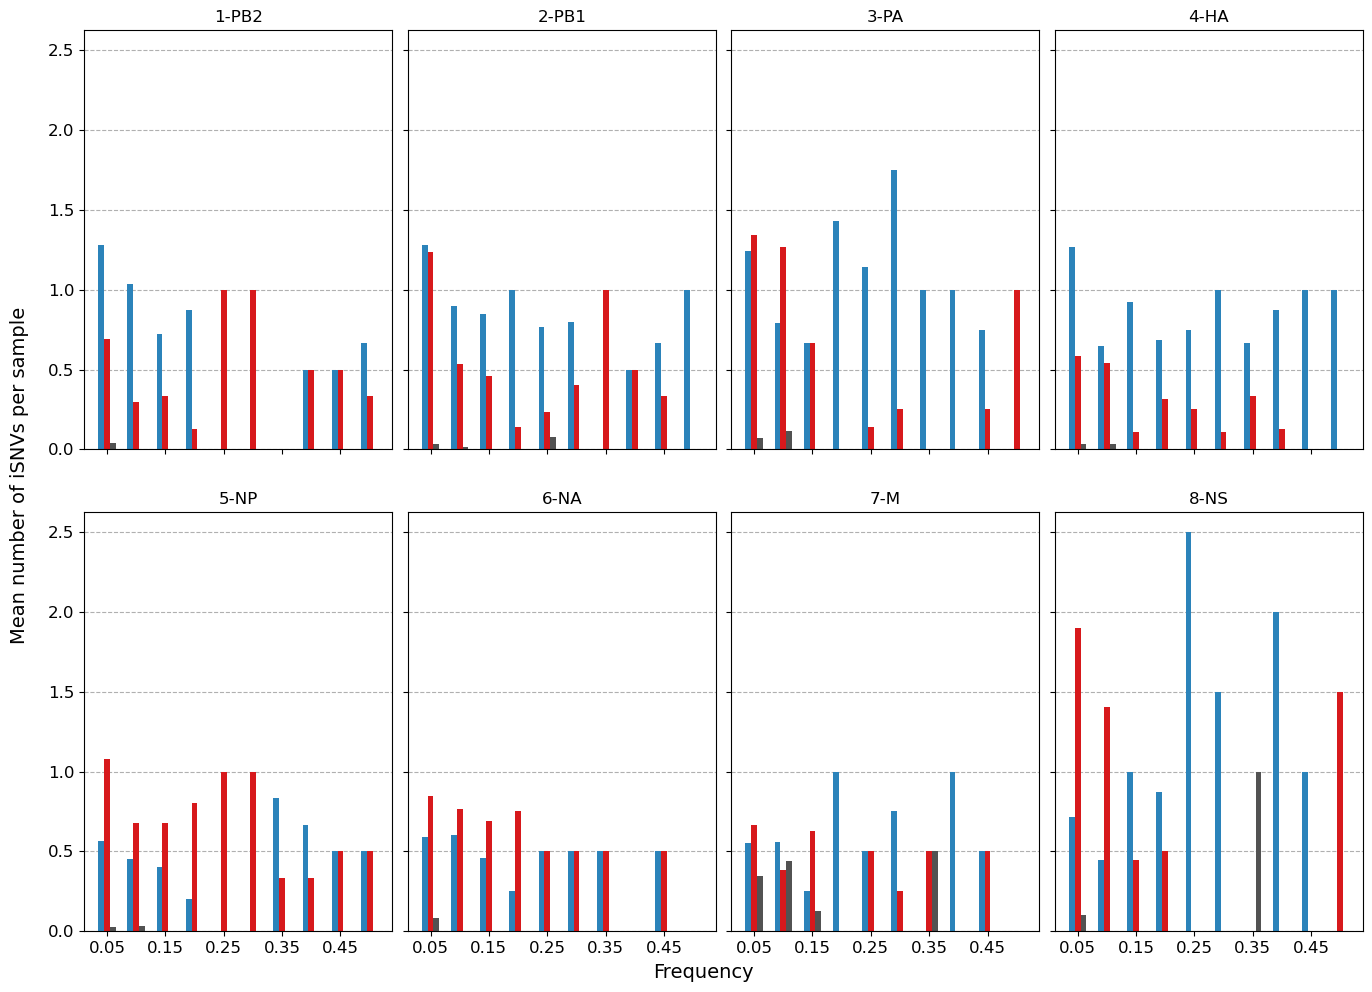

,NS,S,Stop,dNdS
gene,,,,
1-PB2,4.780087,5.584608,0.040323,0.855939
2-PB1,4.842111,7.761212,0.126773,0.623886
3-PA,4.919057,9.773592,0.186613,0.503301
4-HA,2.371904,8.818900,0.067767,0.268957
5-NP,6.903033,4.117402,0.058574,1.676551
6-NA,5.056033,3.899774,0.082353,1.296494
7-M,3.424020,5.109548,1.414003,0.670122
8-NS,5.753260,10.037754,1.098592,0.573162


In [16]:
try: 
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index('sampid').sort_index()

try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 
variant_call_df = variant_call_df.set_index(['sampid', 'gene', 'nucpos', 'nuc_var']).sort_index()

with plt.style.context('default'):
    fig, axes = plt.subplots(2, 4, figsize=(16.5, 11.7), sharex=True, sharey=True)
    gene_dNdS = []
    for gidx, gene in enumerate(sorted_refnames):
        # get ax coordinates
        plot_row = 0 if gidx < 4 else 1 
        plot_col = gidx%4
        #print (plot_row, plot_col)
        ax = axes[(plot_row, plot_col)]
        
        # filter vcf for gene 
        gene_vcf = variant_call_df.xs(gene, level=1)
        
        freq_to_count = {}
        bins = np.arange(0.05, 0.55, 0.05)

        for freq in bins: 
            freq_gene_vcf = gene_vcf[(gene_vcf['nuc_prop']<freq)&(gene_vcf['nuc_prop']>=freq-0.05)].copy()

            # filter sampids where all gene segments fulfill min_breadth requirement 
            sampid_list = list(set(freq_gene_vcf.index.get_level_values(0)))
            sampid_list = list(set(sampid_list)&set(meta_df.index))
            sampid_list = list(meta_df.loc[sampid_list][(meta_df.loc[sampid_list][sorted_refnames]>min_breadth).all(axis=1)].index)
            freq_gene_vcf = freq_gene_vcf[freq_gene_vcf.index.get_level_values(0).isin(sampid_list)]

            if len(freq_gene_vcf) == 0: 
                # do something
                continue 

            # separate into synonymous and nonsynonymous substitutions 
            nonsyn_count = 0
            syn_count = 0
            stop_count = 0

            for idx in freq_gene_vcf.index: 
                # nucleotide mutation leads to either syn or nonsyn sub for any protein gene encodes
                if isinstance(freq_gene_vcf.loc[idx], pd.Series) == True:
                    if freq_gene_vcf.loc[idx, 'nonsyn'] < 0:
                        stop_count += 1
                    elif freq_gene_vcf.loc[idx, 'nonsyn'] > 0:
                        nonsyn_count += 1
                    else: 
                        syn_count += 1
                else: 
                    if len(freq_gene_vcf.loc[idx]) == 1 or len(set(freq_gene_vcf.loc[idx, 'nonsyn'])) == 1: 
                        if freq_gene_vcf.loc[idx, 'nonsyn'].iloc[0] < 0: 
                            stop_count += 1
                        elif freq_gene_vcf.loc[idx, 'nonsyn'].iloc[0] > 0: 
                            nonsyn_count += 1
                        else: 
                            syn_count += 1
                    else: 
                        # for each protein that the gene encodes 
                        idx_freq_gene_vcf = freq_gene_vcf.loc[idx]
                        for protein in set(idx_freq_gene_vcf['protein']): 
                            protein_idx_freq_gene_vcf = idx_freq_gene_vcf[idx_freq_gene_vcf['protein']==protein]

                            # nucleotide mutation leads to either syn or nonsyn sub for protein 
                            if len(protein_idx_freq_gene_vcf) == 1: 
                                if freq_gene_vcf.loc[idx, 'nonsyn'].iloc[0] < 0: 
                                    stop_count += 1
                                elif freq_gene_vcf.loc[idx, 'nonsyn'].iloc[0] > 0: 
                                    nonsyn_count += 1
                                else: 
                                    syn_count += 1
                            else: 
                                # nucleotide mutation leads to both syn and nonsyn sub
                                display (protein_idx_freq_gene_vcf)
                                # continue if not enough aa_consensus 
                                if protein_idx_freq_gene_vcf['aa_coverage'].iloc[0]<min_cov: 
                                    continue 
                                else: 
                                    nonsyn_prop = protein_idx_freq_gene_vcf[protein_idx_freq_gene_vcf['nonsyn']>0]['aa_prop'].sum()
                                    syn_prop = protein_idx_freq_gene_vcf[protein_idx_freq_gene_vcf['nonsyn']<1.]['aa_prop'].sum()
                                    #! -- need to fix this -- #
                                continue 

            total_num_of_samples = len(set(freq_gene_vcf.index.get_level_values(0)))

            rounded_freq = np.around(freq, 2)
            if rounded_freq > 0.5: 
                continue 
            try:
                freq_to_count[rounded_freq]["Synonymous"] += syn_count/total_num_of_samples
                freq_to_count[rounded_freq]["Nonsynonymous"] += nonsyn_count/total_num_of_samples
                freq_to_count[rounded_freq]["Stop"] += stop_count/total_num_of_samples
            except: 
                freq_to_count[rounded_freq] = {"Synonymous":syn_count/total_num_of_samples, 
                                               "Nonsynonymous":nonsyn_count/total_num_of_samples, 
                                               "Stop":stop_count/total_num_of_samples}

        gene_iSNVfreq_distributions = []
        for freq, count_dict in freq_to_count.items(): 
            row = {"Frequency":freq}
            for k, v in count_dict.items():
                row[k] = v
            gene_iSNVfreq_distributions.append(row)

        gene_iSNVfreq_distributions = pd.DataFrame.from_dict(gene_iSNVfreq_distributions)
        gene_iSNVfreq_distributions = gene_iSNVfreq_distributions.set_index("Frequency")
        #display (gene_iSNVfreq_distributions.head())
        
        gene_dNdS.append({"gene":gene,
                          "NS":gene_iSNVfreq_distributions['Nonsynonymous'].sum(), 'S':gene_iSNVfreq_distributions['Synonymous'].sum(), 
                          "Stop":gene_iSNVfreq_distributions['Stop'].sum(), 
                          "dNdS":gene_iSNVfreq_distributions['Nonsynonymous'].sum()/gene_iSNVfreq_distributions['Synonymous'].sum()})

        #gene_iSNVfreq_distributions.plot.bar(ax=ax, fontsize=12, color=['#2b83ba', '#d7191c'], )

        labels = list(gene_iSNVfreq_distributions.index)
        x = [] # the label locations
        lidx = 0 
        for bidx, b in enumerate(bins): 
            if lidx >= len(labels): 
                break 
            if np.isclose(labels[lidx], b): 
                x.append(bidx)
                lidx += 1
        x = np.array(x)
        width = 0.2  # the width of the bars
        
        ax.bar(x - width, gene_iSNVfreq_distributions['Synonymous'], width, label='Synonymous', color="#2b83ba")
        ax.bar(x, gene_iSNVfreq_distributions['Nonsynonymous'], width, label='Nonsynonymous', color="#d7191c")
        ax.bar(x + width, gene_iSNVfreq_distributions['Stop'], width, label='Stop', color="#525252")

        # grid lines 
        ax.grid(axis='y', ls='--', zorder=0)
        ax.set_axisbelow(True)

        # labels
        ax.set_title(gene)

        ax.set_xticks([bidx for bidx, b in enumerate(bins) if bidx%2==0])
        ax.set_xticklabels(["%.2f"%(b) for bidx, b in enumerate(bins) if bidx%2==0])
        
        ax.tick_params(which="both", labelsize=12)
        
    # y-axis label 
    fig.text(0.08, 0.5, 'Mean number of iSNVs per sample', va='center', 
             fontsize=14, rotation=90)
    # x-axis label
    fig.text(0.5, 0.07, "Frequency", ha='center', 
             fontsize=14)
    
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    plt.savefig('./results/figures/syn_nonsyn_histogram_gene.pdf',
                bbox_inches='tight', pad_inches=0.)
    plt.show()
    
    gene_dNdS = pd.DataFrame.from_dict(gene_dNdS).set_index("gene").sort_index()
    gene_dNdS.to_csv("./results/gene_dNdS.csv")
    display (gene_dNdS)

# Compare iSNVs between HA antigenic and non-antigenic sites

Synonymous


MannwhitneyuResult(statistic=5375.0, pvalue=1.1779638118531552e-24)

0.1408839779005525 0.08670279283034597 0.2714363735663572
0.032430213464696225 0.025705316025319874 0.04897063063357105 

Nonsynonymous


MannwhitneyuResult(statistic=3908.5, pvalue=0.2780261675066157)

0.03505740057400574 0.025879385025465274 0.06393760632927149
0.03457359236088245 0.0241546008763574 0.056083889497052106 



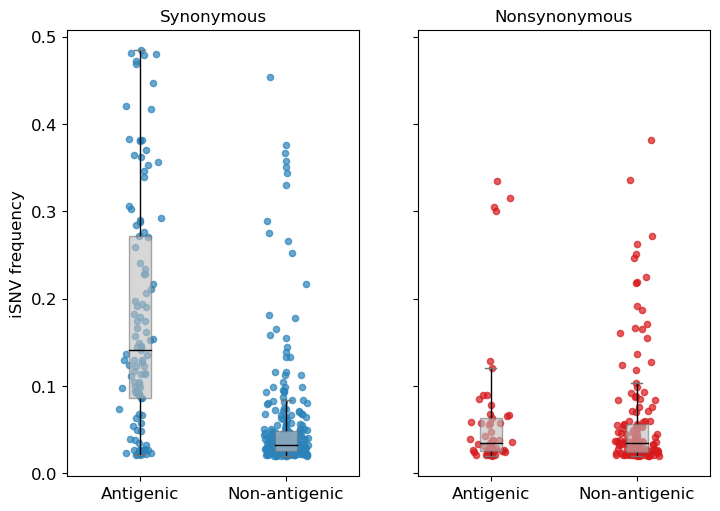

In [17]:
# compare HA antigenic and non-antigenic sites 
y_values = {0:[[], []], 1:[[], []]}

try: 
    variant_call_df = variant_call_df.reset_index()
except:
    pass 
variant_call_df = variant_call_df.set_index(["sampid", "gene", "nucpos"])

for nonsyn_bool in range(2): 
    ha_vcf = variant_call_df.xs("4-HA", level=1)
    ha_vcf = ha_vcf[ha_vcf['nonsyn']==nonsyn_bool]
    
    for idx in ha_vcf.index: 
        idx_ha_vcf = ha_vcf.loc[idx]

        if isinstance(idx_ha_vcf, pd.Series): 
            idx_ha_vcf = idx_ha_vcf.to_frame().T

        sampid, nucpos = idx 
        
        if pd.isna(ha_numbering_conversion.loc[gene_to_proteinorf.loc[("4-HA", nucpos), 'aa'].iloc[0], subtype_ant]):
            # non-antigenic site 
            y_values[nonsyn_bool][1].append(idx_ha_vcf['nuc_prop'].iloc[0])
        else:
            y_values[nonsyn_bool][0].append(idx_ha_vcf['nuc_prop'].iloc[0])

with plt.style.context('default'):
    fig, axes = plt.subplots(1, 2, figsize=(8.3, 5.8), sharey=True)
    color_scheme=['#2b83ba', '#d7191c']

    for nonsyn_bool in range(2): 
        print ("Synonymous" if nonsyn_bool == 0 else "Nonsynonymous")
        display (mannwhitneyu(y_values[nonsyn_bool][0], y_values[nonsyn_bool][1]))
        med_x = np.median(y_values[nonsyn_bool][0])
        print (med_x, np.quantile(y_values[nonsyn_bool][0], 0.25), np.quantile(y_values[nonsyn_bool][0], 0.75))    

        med_x = np.median(y_values[nonsyn_bool][1])
        print (med_x, np.quantile(y_values[nonsyn_bool][1], 0.25), np.quantile(y_values[nonsyn_bool][1], 0.75), "\n")    

        ax = axes[nonsyn_bool]

        ax.boxplot(y_values[nonsyn_bool], patch_artist=True,
                   boxprops=dict(facecolor="#bdbdbd", color="#737373", alpha=0.6),
                   capprops=dict(color="#737373"),
                   whiskerprops=dict(color="#000000"),
                   flierprops=dict(markeredgecolor="#bdbdbd", markerfacecolor="#bdbdbd", marker='.', alpha=0.),
                   medianprops=dict(color="#000000"),)

        # plot actual data as jitter 
        for idx, yval in enumerate(y_values[nonsyn_bool]):
            idx += 1
            try: 
                ax.scatter(get_jitter_xvals(yval, center_x=idx,  width=0.3), 
                           yval, s=20, c=color_scheme[nonsyn_bool], alpha=.7)
            except:  
                ax.scatter([idx*2-0.4]*len(yval),
                           yval, s=20, c=color_scheme[nonsyn_bool], alpha=.7)

        ax.tick_params(axis='both', which='major', labelsize=12)
        # xtick labels
        ax.set_xticklabels(["Antigenic", "Non-antigenic"])

        if nonsyn_bool == 0: 
            ax.set_title("Synonymous", fontsize=12)
        else: 
            ax.set_title("Nonsynonymous", fontsize=12)

    # ytick
    #ax.set_ylim((0., 0.1))
    axes[0].set_ylabel("iSNV frequency", fontsize=12)

    plt.savefig('./results/figures/HA_ant_compare.pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

# Polymorphic nonsynonymous sites across individuals

In [18]:
try:
    variant_call_df = variant_call_df.reset_index()
except:  
    pass 
variant_call_df = variant_call_df.set_index(['sampid', 'gene', 'nucpos'])

try: 
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index('sampid').sort_index()

subject_nuc_mutation_dict = {}
for sampid in meta_df.index: 
    # subject_id 
    subject_id = meta_df.loc[sampid, 'subject_id']
    
    # filter for gene segments > min_breadth 
    genes_to_analyse = meta_df.loc[sampid][sorted_refnames]
    genes_to_analyse = list(genes_to_analyse[genes_to_analyse>min_breadth].index)
    
    """# here, we accept any samples for the gene segment > min_breadth 
    if len(genes_to_analyse) < 8: 
        continue """
    
    for gene in genes_to_analyse: 
        try: 
            gene_vcf = variant_call_df.loc[(sampid, gene)].copy()
        except: 
            # no mutations found in gene 
            continue 
        
        # only for variants >2% 
        gene_vcf = gene_vcf[gene_vcf['nuc_prop']>=0.02]
        
        for nucpos in set(gene_vcf.index):
            if isinstance(gene_vcf.loc[nucpos, 'nonsyn'], pd.Series): 
                nucpos_gene_vcf = gene_vcf.loc[nucpos] 
                if len(nucpos_gene_vcf) == 0: # stop codons are ignored 
                    continue
                nonsyn = max(nucpos_gene_vcf['nonsyn'])
                nuc_prop = nucpos_gene_vcf['nuc_prop'].iloc[0]
            else: 
                nonsyn = gene_vcf.loc[nucpos, 'nonsyn']
                nuc_prop = gene_vcf.loc[nucpos, 'nuc_prop']
                
            try:
                subject_nuc_mutation_dict[gene][nonsyn][nucpos].append((subject_id, nuc_prop))
            except: 
                try: 
                    subject_nuc_mutation_dict[gene][nonsyn][nucpos] = [(subject_id, nuc_prop)]
                except:  
                    try: 
                        subject_nuc_mutation_dict[gene][nonsyn] = {nucpos:[(subject_id, nuc_prop)]}
                    except: 
                        subject_nuc_mutation_dict[gene] = {nonsyn:{nucpos:[(subject_id, nuc_prop)]}}
          
# convert subject_nuc_mutation_dict to dataframe
subject_nuc_mutation_df = []
for gene, nonsyn_to_nucpos_to_subject_np_list in subject_nuc_mutation_dict.items():
    for nonsyn, nucpos_to_subject_np_list in subject_nuc_mutation_dict[gene].items(): 
        for nucpos, subject_np_list in subject_nuc_mutation_dict[gene][nonsyn].items():
            subject_num = len(set([_[0] for _ in subject_np_list]))
            
            """if gene == "7-M" and nucpos == 917: # aa_var = stop codon
                continue""" 
                
            nuc_prop_dist = [_[-1] for _ in subject_np_list]
            subject_nuc_mutation_df.append({'gene':gene, 'nucpos':nucpos, 'nonsyn':nonsyn, 
                                            'subject_num':subject_num, 'mean_prop':nuc_prop_dist}) 
subject_nuc_mutation_df = pd.DataFrame.from_dict(subject_nuc_mutation_df)
subject_nuc_mutation_df = subject_nuc_mutation_df.set_index(['gene', 'nonsyn', 'nucpos']).sort_index()
subject_nuc_mutation_df.head()

subject_num               mean_prop
gene  nonsyn nucpos                                     
1-PB2 -1.0   16                1     [0.026578073089701]
             35                1  [0.020270270270270268]
             214               1  [0.020531400966183576]
             1346              1    [0.0281439925198691]
             1598              1   [0.02834008097165992]

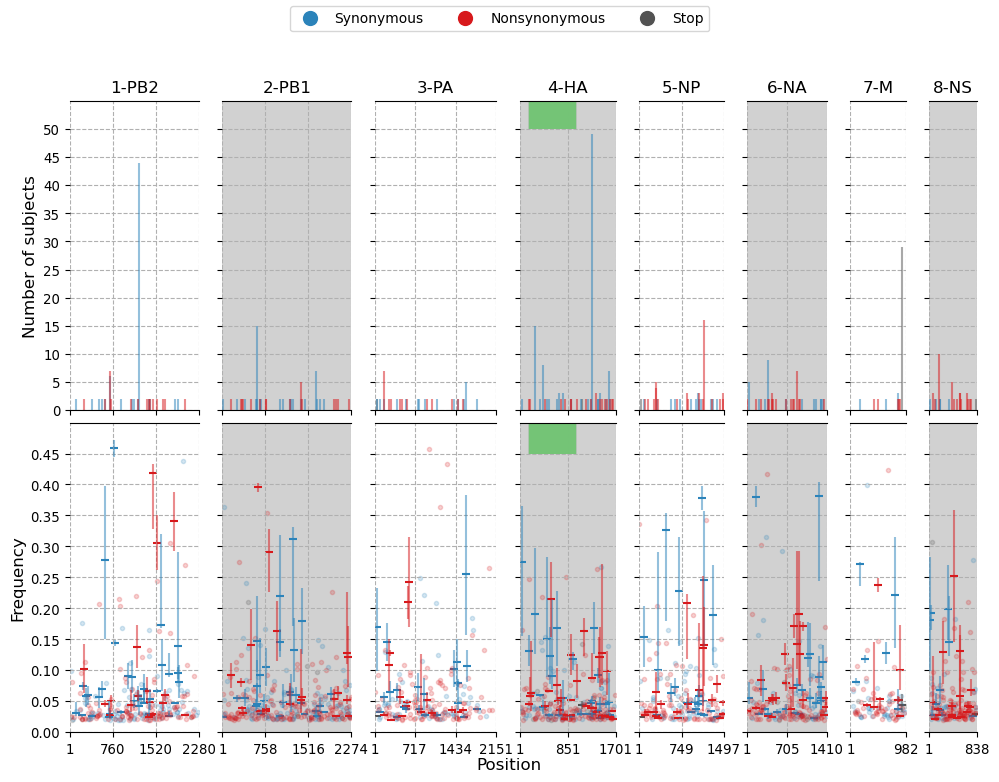

In [19]:
with plt.style.context('default'):
    # initialise coverage plot figure 
    fig = plt.figure(figsize=(11.7, 8.2))#, constrained_layout=True)
    color_label_dict = {0.:('#2b83ba', 'Synonymous'), 1.:('#d7191c', 'Nonsynonymous'), -1.:("#525252", "Stop")}
    label_size = 12

    # array of sorted segment length 
    sorted_gene_len = np.array([influenza_gene_len[refname] for refname in sorted(influenza_gene_len.keys())])

    for _p, plot_item in enumerate(['subject_num', 'mean_prop']):

        spec = gridspec.GridSpec(2, 8, figure=fig,
                                 width_ratios=sorted_gene_len/np.sum(sorted_gene_len))
        spec.update(wspace=0.25, hspace=0.04) # set the spacing between axes. 

        axes = [] # list of subplots (by segments)

        # add subplot for 1st sample 
        for refname in sorted(set(subject_nuc_mutation_df.index.get_level_values(0))): 
            _r = int(re.search('^\d+', refname).group())-1

            ax = fig.add_subplot(spec[_p, _r])
            if _p == 0:
                ax.set_title(refname, fontsize=label_size) # title 

            refname_subject_nuc_mutation_df = subject_nuc_mutation_df.loc[refname]
            # filter for positions where polymorphisms observed for > 1 subject

            # plot syn
            for nonsyn_bool in sorted(set(refname_subject_nuc_mutation_df.index.get_level_values(0))): 
                if pd.isna(nonsyn_bool): # unable to determine if they are syn/nonysn/stop
                    continue 
                    
                if nonsyn_bool > 0 and refname == '4-HA': 
                    # mark HA antigenic sites 
                    ant_sites = list(ha_numbering_conversion[~pd.isna(ha_numbering_conversion[subtype_ant])].index)
                    ant_sites = list(gene_to_proteinorf.loc['4-HA'][gene_to_proteinorf.loc['4-HA']['aa'].isin(ant_sites)].index.get_level_values(0))
                    ax.vlines(ant_sites, [50 if _p == 0 else 0.45]*len(ant_sites), [100]*len(ant_sites), color='#74c476', alpha=0.5)

                if plot_item == 'subject_num':
                    nonsyn_refname_subject_nuc_mutation_df = refname_subject_nuc_mutation_df.loc[nonsyn_bool]
                    nonsyn_refname_subject_nuc_mutation_df = nonsyn_refname_subject_nuc_mutation_df[nonsyn_refname_subject_nuc_mutation_df['subject_num']>1]
                    x_values = sorted(list(nonsyn_refname_subject_nuc_mutation_df.index))

                    y_values = [nonsyn_refname_subject_nuc_mutation_df.loc[nucpos, plot_item] for nucpos in x_values]
                    ax.vlines(x_values, [0]*len(x_values), y_values, 
                              color=color_label_dict[nonsyn_bool][0], 
                              label=color_label_dict[nonsyn_bool][-1],
                              alpha=0.5)

                    #if nonsyn_bool > 0 or nonsyn_bool < 0:   
                    #    print (refname, [nucpos for idx, nucpos in enumerate(x_values) if y_values[idx]>2], nonsyn_bool)
                else: 
                    nonsyn_refname_subject_nuc_mutation_df = refname_subject_nuc_mutation_df.loc[nonsyn_bool]
                    x_values = sorted(list(nonsyn_refname_subject_nuc_mutation_df.index))

                    # for prop dist 
                    # plot scatter mean 
                    y_values = [nonsyn_refname_subject_nuc_mutation_df.loc[nucpos, plot_item] for nucpos in x_values]

                    # for sites where variants were found in > 1 subject 
                    ax.scatter([x_values[idx] for idx, y_val in enumerate(y_values) if len(y_val) > 1], 
                               [np.median(y_val) for y_val in y_values if len(y_val) > 1], marker='_',
                               color=color_label_dict[nonsyn_bool][0], 
                               label=color_label_dict[nonsyn_bool][-1])
                    ax.vlines([x_values[idx] for idx, y_val in enumerate(y_values) if len(y_val) > 1], 
                              [np.quantile(y_val, 0.25) for y_val in y_values if len(y_val) > 1],
                              [np.quantile(y_val, 0.75) for y_val in y_values if len(y_val) > 1],
                              color=color_label_dict[nonsyn_bool][0],
                              label=color_label_dict[nonsyn_bool][-1], alpha=0.5)

                    # sites where only variant was only found in 1 subject 
                    ax.scatter([x_values[idx] for idx, y_val in enumerate(y_values) if len(y_val) == 1], 
                               [y_val for y_val in y_values if len(y_val) == 1], marker='.',
                               color=color_label_dict[nonsyn_bool][0], alpha=0.2,
                               label=color_label_dict[nonsyn_bool][-1])


            axes.append(ax)

        for _ax, ax in enumerate(axes):
            # change yticks 
            if plot_item == 'subject_num':
                ax.set_ylim((0, 55))
                ax.set_yticks(np.linspace(0, 50, 11))
            else: 
                ax.set_ylim((0, .5))
                ax.set_yticks(np.around(np.linspace(0, 0.45, 10), 2))

            if _ax == 0: 
                if plot_item == 'subject_num':
                    ax.set_ylabel('Number of subjects')
                else: 
                    ax.set_ylabel('Frequency')
                ax.yaxis.label.set_fontsize(label_size)
            else: 
                # remove y-axis label (sharey)
                ax.tick_params(labelleft=False)

            # gray facecolor for odd panels 
            if (_ax%2 != 0): 
                ax.set_facecolor(color='#d1d1d1')

            # remove left and right spines 
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # set xlim and xtick labels
            refname = sorted(influenza_gene_len.keys())[_ax]
            refseq_len = influenza_gene_len[refname]
            gene_start_pos = 1
            gene_end_pos = gene_start_pos+refseq_len

            ax.set_xlim(gene_start_pos, gene_end_pos+1)
            if refseq_len > 2000: 
                ax.set_xticks(np.linspace(gene_start_pos, gene_end_pos-1, 4))
                ax.set_xticklabels(map(int, np.linspace(gene_start_pos,  gene_end_pos-1, 4)))
            elif refseq_len > 1000: 
                ax.set_xticks(np.linspace(gene_start_pos, gene_end_pos-1, 3))
                ax.set_xticklabels(map(int, np.linspace(gene_start_pos,  gene_end_pos-1, 3)))
            else: 
                ax.set_xticks(np.linspace(gene_start_pos, gene_end_pos-1, 2))
                ax.set_xticklabels(map(int, np.linspace(gene_start_pos,  gene_end_pos-1, 2)))

            # remove xticks for top row panels
            if _p == 0:
                ax.set_xticklabels([])

            # change tick size 
            ax.tick_params(axis='both', which='major', labelsize=label_size*0.8)

            # grid lines 
            ax.grid(axis='both', ls='--', zorder=0)

            # change axis size 
            ax.xaxis.label.set_fontsize(label_size)

    # x-axis label 
    fig.text(0.5, 0.065, 'Position', ha='center', fontsize=label_size)

    # legend 
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Synonymous',
                              markerfacecolor='#2b83ba', markersize=12), 
                       Line2D([0], [0], marker='o', color='w', label='Nonsynonymous',
                              markerfacecolor='#d7191c', markersize=12), 
                       Line2D([0], [0], marker='o', color='w', label='Stop',
                              markerfacecolor='#525252', markersize=12)]
    fig.legend(handles=legend_elements, loc='upper center', fontsize=10, ncol=3)

    #plt.tight_layout()
    plt.savefig('./results/figures/polymorphic_sites.pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

# Plotting nonsynonymous iSNV proportions against time

In [22]:
if os.path.isfile("./results/aa_substitution_trace.csv"):
    aa_substitution_trace = pd.read_csv("./results/aa_substitution_trace.csv")
    aa_substitution_trace['protein'] = aa_substitution_trace["protein"].fillna("NA")
else:
    aa_substitution_trace = []

    try: 
        meta_df = meta_df.reset_index()
    except: 
        pass 
    
    try: 
        variant_call_df = variant_call_df.reset_index()
    except: 
        pass

    rev_codon_table = {}
    for k,v in codon_table.items():
        try:
            rev_codon_table[v].append(k)
        except:
            rev_codon_table[v] = [k]

    #filter_dict = {"NA":[292, 329, 119], "NP":[101, 384], "M2":[77]}

    meta_df = meta_df.set_index(["subject_id", "timepoint"]).sort_index()

    subject_list = sorted(set(meta_df[meta_df["sampid"].isin(variant_call_df["sampid"])].index.get_level_values(0)))
    for subject_id in subject_list:
        # get subject timeline to sampid dictionary 
        subject_meta_df = meta_df.loc[subject_id].copy()
        timepoint_to_sampid = {int(timepoint):subject_meta_df.loc[timepoint, "sampid"] for timepoint in sorted(subject_meta_df.index) if not pd.isna(timepoint)}
        sampid_to_timepoint = {v:k for k, v in timepoint_to_sampid.items()}

        if len(timepoint_to_sampid) == 0: 
            print ("Dont know DaysSincneOnset for %i"%(subject_id))
            continue 

        # get subject variant calls 
        subject_vcf = variant_call_df[variant_call_df["sampid"].isin(subject_meta_df['sampid'])].copy()
        subject_vcf = subject_vcf.set_index(["gene", "nucpos", "sampid"]).sort_index()
        # only look at nonsyn/nonsense iSNVs
        subject_vcf =  subject_vcf[(subject_vcf["nonsyn"]>0)|(subject_vcf['nonsyn']<0)]

        # for each iSNV 
        for (gene, nucpos) in sorted(set(zip(subject_vcf.index.get_level_values(0), subject_vcf.index.get_level_values(1)))):
            isnv_subject_vcf = subject_vcf.loc[(gene, nucpos)]
            for protein in set(isnv_subject_vcf["protein"]):

                """
                # filter 
                if protein != "HA":
                    if protein not in filter_dict.keys():
                        continue
                """ 

                protein_isnv_subject_vcf = isnv_subject_vcf[isnv_subject_vcf["protein"]==protein]

                for aapos in sorted(set(protein_isnv_subject_vcf["aapos"])): 
                    aapos_protein_isnv_subject_vcf = protein_isnv_subject_vcf[protein_isnv_subject_vcf["aapos"]==aapos]

                    # HA position 
                    abs_HAnum = 0
                    HA_ant = None
                    if protein == "HA": 
                        if re.search("abs", aapos_protein_isnv_subject_vcf["HA_num_type"].iloc[0]):
                            abs_HAnum = 1
                        else:
                            # get canonical ant site classification 
                            HA_ant = ha_numbering_conversion[ha_numbering_conversion[HAnum_subtype]==aapos][subtype_ant].iloc[0]
                    """
                    if pd.isna(HA_ant): 
                        continue

                    else: 
                        if aapos not in filter_dict[protein]:
                            continue
                    """

                    # get aa variants for each aapos 
                    aa_variants = list(set(aapos_protein_isnv_subject_vcf["aa_var"])|set(aapos_protein_isnv_subject_vcf["aa_consensus"]))

                    first_entry_boolean = 1 # boolean to determine aa_consensus 
                    for timepoint in sorted(timepoint_to_sampid.keys()):
                        sampid = timepoint_to_sampid[timepoint]
                        # gene must > min_breadth 
                        if (subject_meta_df.loc[timepoint, gene] < min_breadth): 
                            continue 

                        # get sample map_codon_results 
                        try:
                            map_codon_results = pd.read_csv("./results/map_codon_results_%s.csv"%(sampid))
                        except: 
                            continue 
                        map_codon_results = map_codon_results.set_index(["Gene", "Position"])

                        # get codons translating to aa_variants 
                        nucaa_coords = gene_to_proteinorf.loc[gene].xs(protein, level=1)
                        if protein == "HA" and abs_HAnum == 0:
                            abs_aapos = list(ha_numbering_conversion[ha_numbering_conversion[HAnum_subtype]==aapos].index)[0]
                            frame1_nucpos = list(nucaa_coords[(nucaa_coords["aa"]==abs_aapos)&(nucaa_coords["frame"]==1)].index)[0]
                        else:
                            frame1_nucpos = list(nucaa_coords[(nucaa_coords["aa"]==aapos)&(nucaa_coords["frame"]==1)].index)[0]
                        try: 
                            aapos_codon_df = map_codon_results.loc[(gene, frame1_nucpos)]
                        except: 
                            continue 

                        # coverage of codon must be > min_cov 
                        aa_coverage = aapos_codon_df.sum()
                        if aa_coverage < min_cov:
                            continue 

                        aa_var_to_freq = {}
                        for aa_var in aa_variants:
                            aa_count = sum([aapos_codon_df.loc[codon] for codon in rev_codon_table[aa_var]])
                            aa_freq = aa_count/aa_coverage

                            # 0 proportion if < min_var_prop  
                            if aa_freq < min_var_prop:
                                aa_freq = 0.
                            # 1 proportion if vice versa 
                            elif aa_freq > 1-min_var_prop:
                                aa_freq = 1. 

                            aa_var_to_freq[aa_var] = aa_freq

                        # check if aa_var is aa_consensus 
                        if first_entry_boolean == 1:
                            if sum(aa_var_to_freq.values()) < 0.5: 
                                continue 
                            aa_consensus = max(aa_var_to_freq.keys(), key=aa_var_to_freq.get)
                            #print (aa_consensus, aa_var_to_freq)
                            first_entry_boolean = 0 

                        for aa_var, aa_freq in aa_var_to_freq.items():
                            if aa_var == aa_consensus: 
                                continue # skip if aa_var == aa_consensus 
                            # save row 
                            aa_substitution_trace.append({"subject_id":subject_id, "protein":protein, "aapos":aapos, "aa_var":aa_var, 
                                                          "timepoint":timepoint, "abs_HAnum":abs_HAnum, "HA_ant":HA_ant, "aa_consensus":aa_consensus, 
                                                          "prop":aa_freq})
                            
    aa_substitution_trace = pd.DataFrame(aa_substitution_trace)
    aa_substitution_trace.to_csv("./results/aa_substitution_trace.csv", index=False)

aa_substitution_trace = aa_substitution_trace.set_index(['subject_id', 'protein', 'aapos', 'aa_var']).sort_index()
display (aa_substitution_trace.head())

timepoint  abs_HAnum HA_ant aa_consensus  \
subject_id protein aapos aa_var                                             
1205       HA      178   *               6          0    NaN            Y   
                         *               7          0    NaN            Y   
                         *               8          0    NaN            Y   
                         *               9          0    NaN            Y   
                         *              10          0    NaN            Y   

                                     prop  
subject_id protein aapos aa_var            
1205       HA      178   *       0.000000  
                         *       0.000000  
                         *       0.029825  
                         *       0.000000  
                         *       0.000000

In [23]:
# add additional metadata on starting Oseltamivir treatment dates 
oseltamivir_dot_meta = pd.read_excel("./input/VE_patients_metadata.xlsx")
oseltamivir_dot_meta = oseltamivir_dot_meta[oseltamivir_dot_meta["FLU TYPE"]=="H3"]
oseltamivir_dot_meta = oseltamivir_dot_meta.set_index("NUMBER")
#display (oseltamivir_dot_meta.head())

try:
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index(["subject_id", "enrolD"])

for subject_id in sorted(set(meta_df.index.get_level_values(0))): 
    IllnessOnsetDayOnEnrol0 = meta_df.loc[(subject_id, 0), "timepoint"]
    
    if not pd.isna(IllnessOnsetDayOnEnrol0): 
        ost_days = []
        ost_row = oseltamivir_dot_meta.loc[subject_id]

        if ost_row["DAY OF TREATMENT BEFORE ENROLMENT"] != "N": 
            ost_days.append(IllnessOnsetDayOnEnrol0-(ost_row["DAY OF TREATMENT BEFORE ENROLMENT"]+1))

        ost_days.append(IllnessOnsetDayOnEnrol0)
        ost_days = ";".join(list(map(lambda _: str(int(_)), ost_days)))
        #
    else: 
        ost_days = ""
    
    meta_df.at[subject_id, "ost_days"] = ost_days
display (meta_df)

sampid  ct  timepoint   idx SampleType  \
subject_id enrolD                                                               
1205       0       H3N2_1205_T0_T_S517_N701_R  26        6.0    R1          T   
           1       H3N2_1205_T1_N_S517_N702_R  25        7.0    R2          N   
           2       H3N2_1205_T2_T_S517_N703_R  30        8.0    R3          T   
           3       H3N2_1205_T3_T_S517_N704_R  29        9.0    R4          T   
           4       H3N2_1205_T4_T_S517_N705_R  28       10.0    R5          T   
...                                       ...  ..        ...   ...        ...   
3613       3       H3N2_3613_T3_T_S504_N706_R  30        6.0  R287          T   
3615       0       H3N2_3615_T0_T_S504_N707_R  24        6.0  R288          T   
           1       H3N2_3615_T1_N_S504_N708_R  28        7.0  R289          N   
           2       H3N2_3615_T2_N_S504_N709_R  36        8.0  R290          N   
           7       H3N2_3615_T7_N_S504_N710_R  31       13.0  R291          N   

                   aliquot  run primer_i5 primer_i7  enrol-onset  ... patch  \
subject_id enrolD                                                 ...         
1205       0             1    1      S517      N701          6.0  ...     0   
           1             1    1      S517      N702          6.0  ...     0   
           2             1    1      S517      N703          6.0  ...     0   
           3             1    1      S517      N704          6.0  ...     0   
           4             1    1      S517      N705          6.0  ...     0   
...                    ...  ...       ...       ...          ...  ...   ...   
3613       3             1    3      S504      N706          3.0  ...     0   
3615       0             1    3      S504      N707          6.0  ...     0   
           1             1    3      S504      N708          6.0  ...     0   
           2             1    3      S504      N709          6.0  ...     0   
           7             1    3      S504      N710          6.0  ...     0   

                      1-PB2  2-PB1      3-PA      4-HA      5-NP      6-NA  \
subject_id enrolD                                                            
1205       0       1.000000    1.0  0.962963  1.000000  1.000000  0.844828   
           1       1.000000    1.0  1.000000  1.000000  1.000000  0.931034   
           2       1.000000    1.0  0.907407  0.985294  0.866667  0.844828   
           3       1.000000    1.0  0.962963  1.000000  0.966667  0.844828   
           4       1.000000    1.0  0.962963  1.000000  1.000000  0.844828   
...                     ...    ...       ...       ...       ...       ...   
3613       3       1.000000    1.0  1.000000  1.000000  1.000000  0.931034   
3615       0       1.000000    1.0  1.000000  1.000000  1.000000  1.000000   
           1       1.000000    1.0  1.000000  1.000000  1.000000  0.965517   
           2       0.566667    1.0  0.962963  1.000000  1.000000  0.827586   
           7       1.000000    1.0  1.000000  1.000000  1.000000  0.982759   

                        7-M      8-NS  ost_days  
subject_id enrolD                                
1205       0       1.000000  0.945946         6  
           1       1.000000  1.000000         6  
           2       1.000000  1.000000         6  
           3       1.000000  1.000000         6  
           4       1.000000  1.000000         6  
...                     ...       ...       ...  
3613       3       1.000000  1.000000      -1;3  
3615       0       1.000000  1.000000       4;6  
           1       1.000000  1.000000       4;6  
           2       0.380952  1.000000       4;6  
           7       1.000000  1.000000       4;6  

[219 rows x 22 columns]

HA
1876-(HA-[B]) D188E [5, 6, 7, 8, 9] [0.0, 0.0, 0.03413498836307215, 0.0, 0.0]
1867-(HA-[C]) N278S [3, 4, 5, 7] [0.020975211114137842, 0.0, 0.0, 0.0]


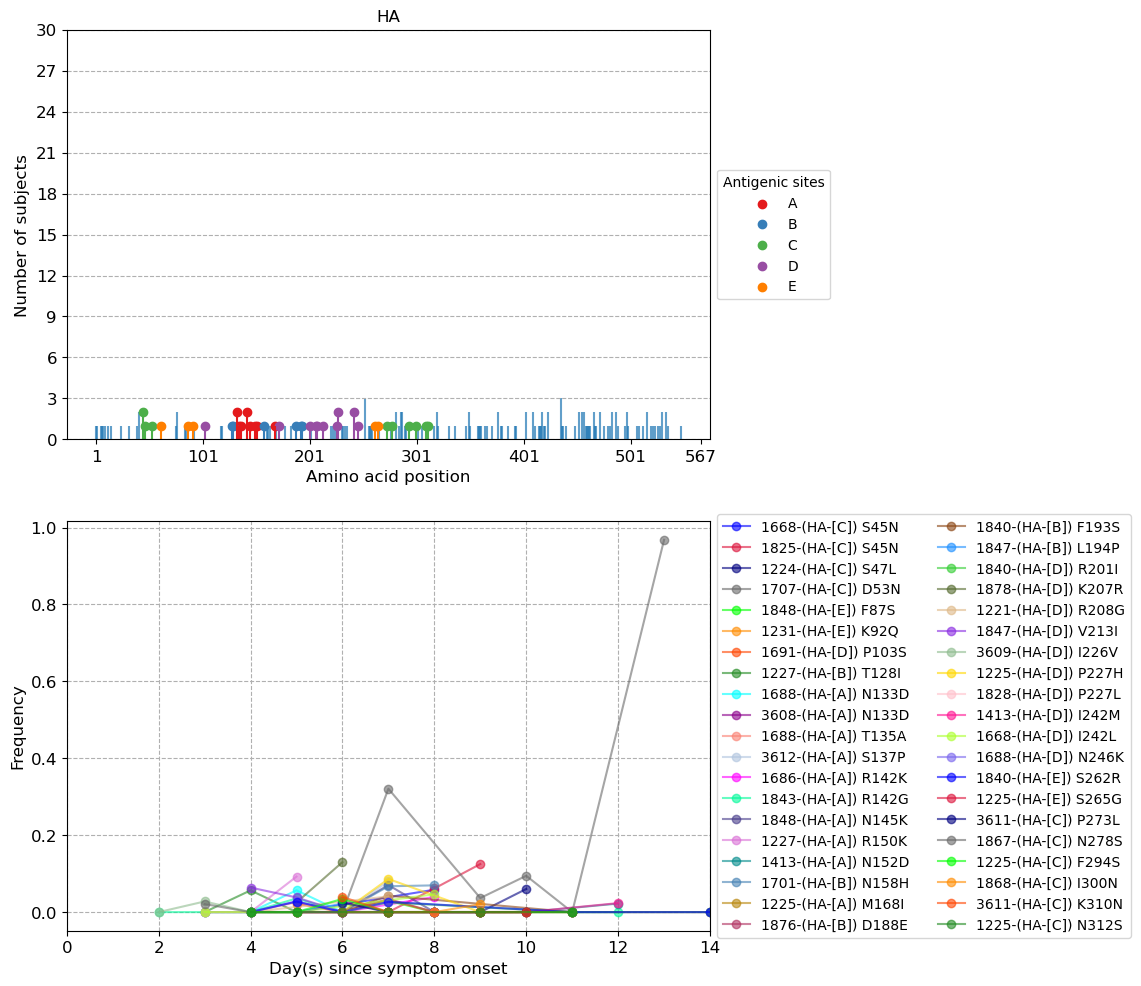

M2


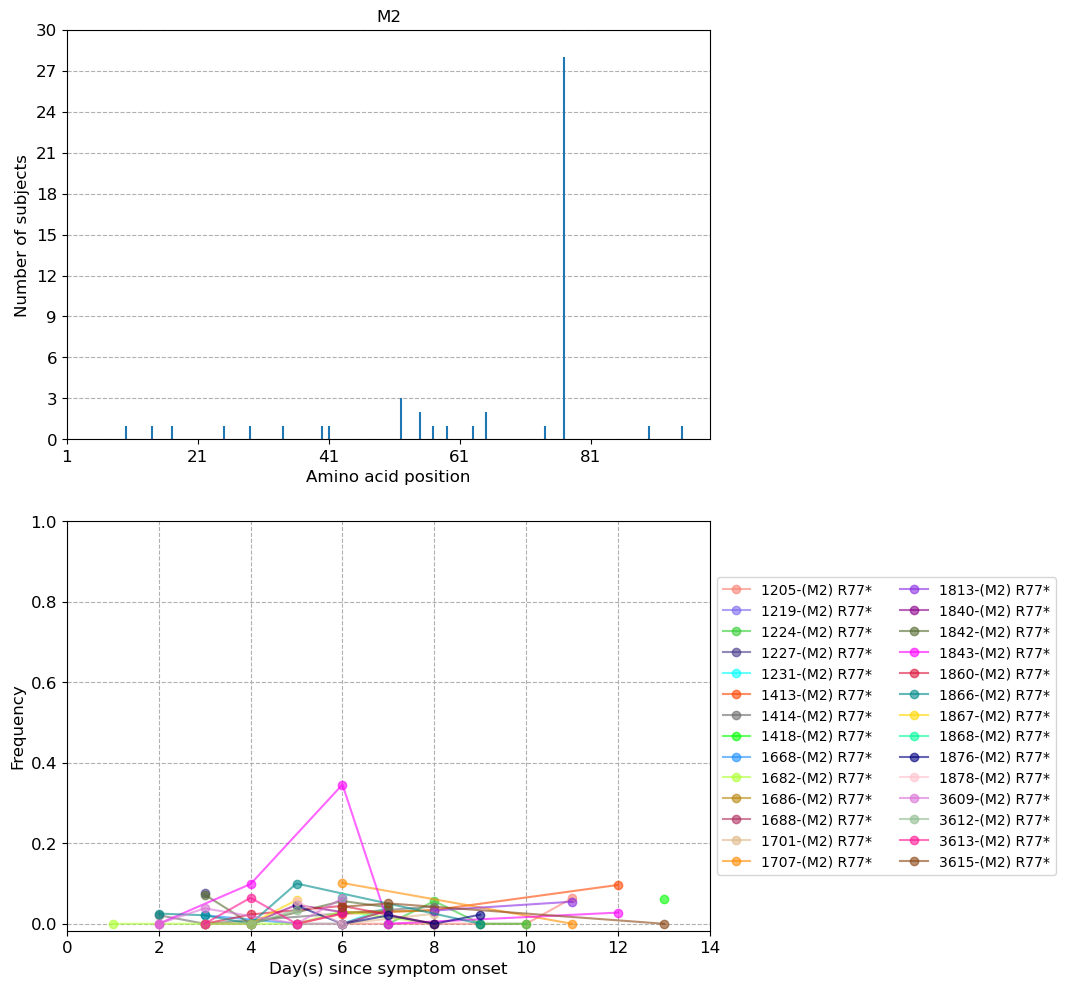

NA
{1: [1682], 5: [1691, 1876], 6: [1707], 4: [1840], 2: [1842], 3: [1860], -1: [3609, 3613]}


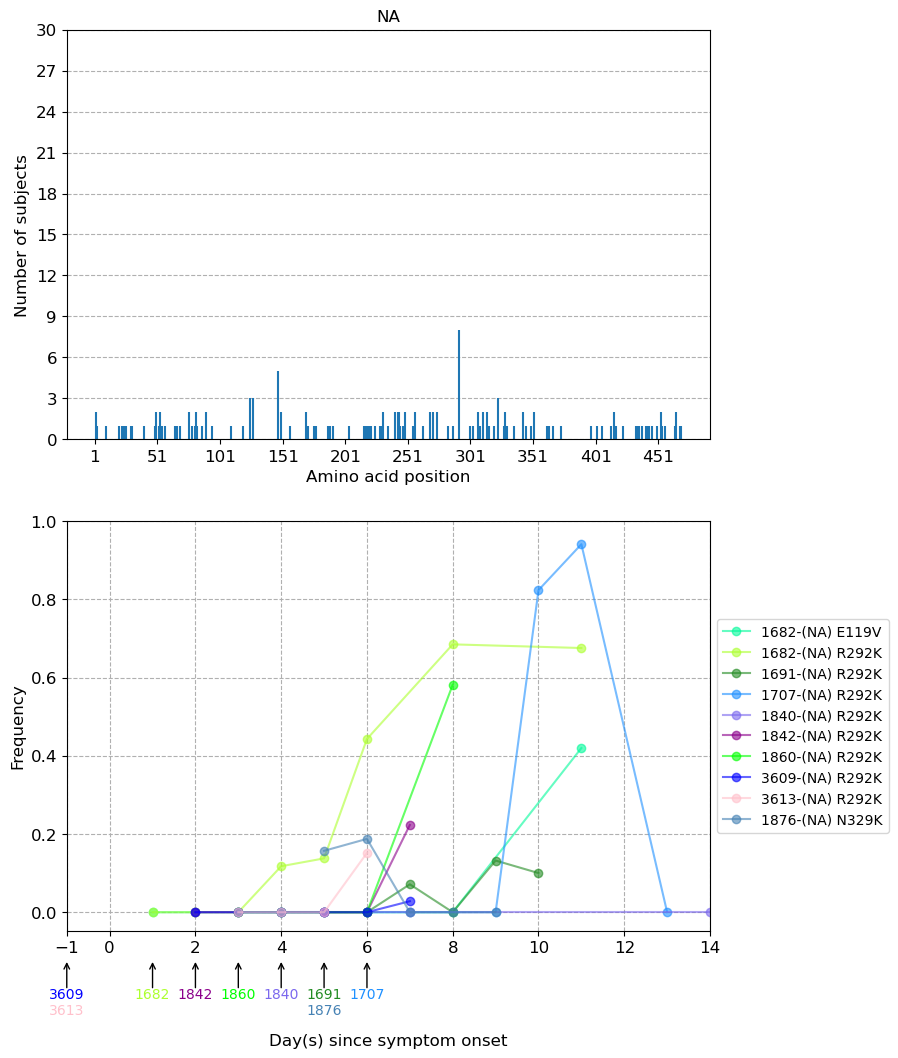

NP


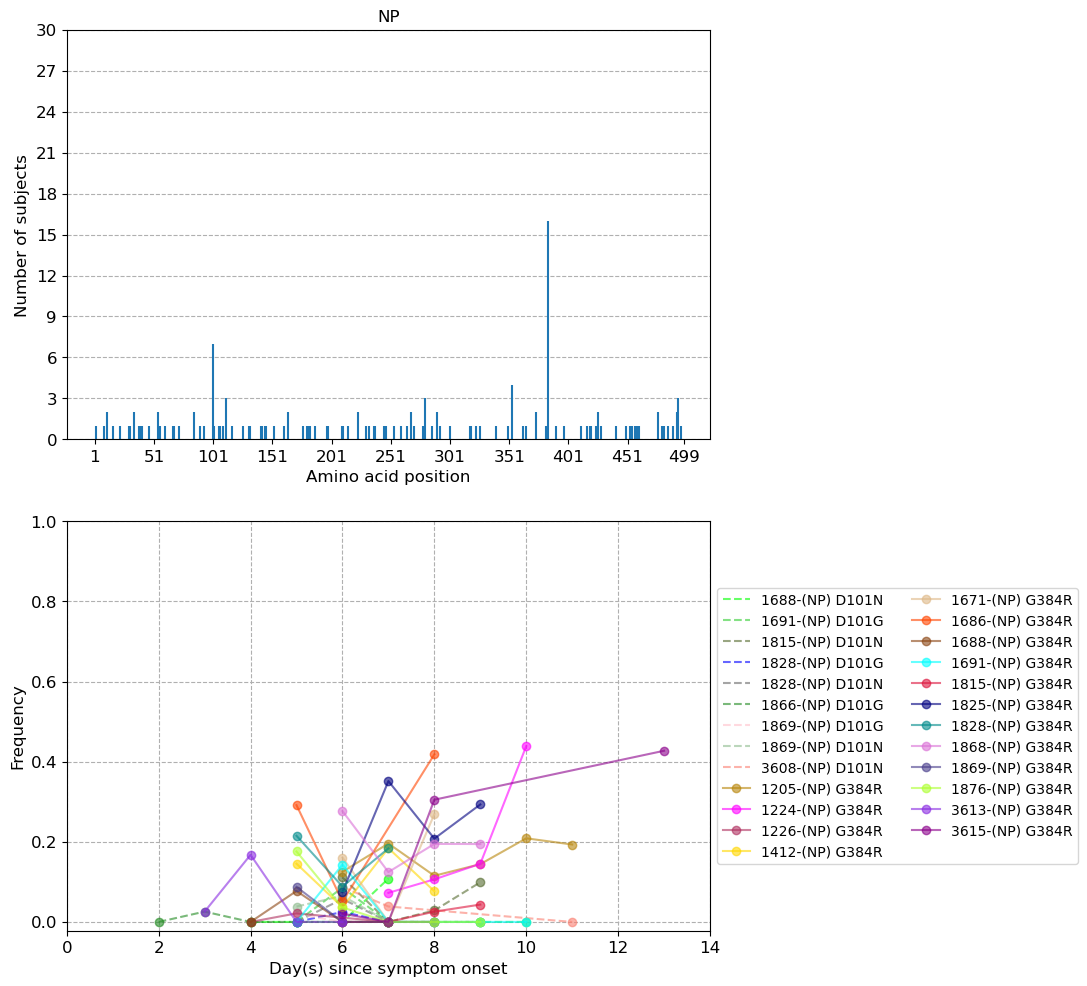

In [24]:
color_list = ["#696969","#556b2f","#8b4513","#228b22","#483d8b","#b8860b","#008b8b","#4682b4",
              "#000080","#32cd32","#8fbc8f","#8b008b","#b03060","#ff4500","#ff8c00","#ffd700",
              "#deb887","#00ff00","#00fa9a","#8a2be2","#dc143c","#00ffff","#0000ff","#adff2f",
              "#da70d6","#b0c4de","#ff00ff","#1e90ff","#fa8072","#ff1493","#7b68ee","#ffc0cb"]
ant_sites_colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]
ant_sites_df = ha_numbering_conversion[~pd.isna(ha_numbering_conversion[subtype_ant])]

filter_dict= {"HA":sorted(set(aa_substitution_trace[~pd.isna(aa_substitution_trace["HA_ant"])].index.get_level_values(2))), "NA":[292, 329, 119], "NP":[101, 384], "M2":[77]}

NP384_freq = []
NA_color = {}

for protein in sorted(set(aa_substitution_trace.index.get_level_values(1))): 
    
    if protein not in filter_dict.keys(): # limit to HA and M 
        continue
    
    print (protein)
    # shuffle color list randomly 
    random.shuffle(color_list)
    
    protein_aa_substitution_trace = aa_substitution_trace.xs(protein, level=1)
    
    # proteinrate two panel plots
    # top panel - x-axis aa pos vs y-axis number of individuals; 
    # bottom panel - temporal changes 
    with plt.style.context("default"):
        fig, axes = plt.subplots(2, 1, figsize=(8.3, 11.7))
        top_x_values = []
        top_y_values = []

        colidx = 0 
        
        if protein == "NA": # for plotting oseltamivir start date 
            oseltamivir_consolidate = {}
            accounted_subject = []
            
        for aapos in sorted(set(protein_aa_substitution_trace.index.get_level_values(1))):
            aapos_protein_aa_substitution_trace = protein_aa_substitution_trace.xs(aapos, level=1)
            
            # skip if mutation only found in 1 subject for 1 timepoint 
            subject_list = list(set(aapos_protein_aa_substitution_trace.index.get_level_values(0)))

            # number of inidividuals and aa position 
            top_x_values.append(aapos)
            top_y_values.append(len(subject_list))

            for subject_id in sorted(subject_list): 
                
                if aapos not in filter_dict[protein]: # only plot trace for filtered positions
                    continue
                
                if protein == "NA": 
                    if subject_id not in accounted_subject: 
                        accounted_subject.append(subject_id)
                        os_treatment_timepoint = list(set(meta_df.loc[subject_id, "ost_days"]))[0]
                        os_treatment_timepoint = sorted(map(int, os_treatment_timepoint.split(";")))
                        
                        try:
                            oseltamivir_consolidate[os_treatment_timepoint[0]].append(subject_id)
                        except:
                            oseltamivir_consolidate[os_treatment_timepoint[0]] = [subject_id]
                        
                subject_aapos_protein_aa_substitution_trace = aapos_protein_aa_substitution_trace.loc[subject_id]

                for aa_var in set(subject_aapos_protein_aa_substitution_trace.index): 
                    if protein == "NA" and aapos == 329 and aa_var == "T": 
                        continue
                    if protein != "M2" and aa_var == "*": 
                        continue 
                        
                    aa_var_subject_aapos_protein_aa_substitution_trace = subject_aapos_protein_aa_substitution_trace.loc[aa_var]
                    try: 
                        btm_x_values = list(aa_var_subject_aapos_protein_aa_substitution_trace['timepoint'])
                    except: 
                        btm_x_values = [aa_var_subject_aapos_protein_aa_substitution_trace['timepoint']]
                        
                    try:
                        btm_y_values = list(aa_var_subject_aapos_protein_aa_substitution_trace['prop'])
                    except: 
                        btm_y_values = [aa_var_subject_aapos_protein_aa_substitution_trace['prop']]
                    
                    sorted_x_values = sorted(btm_x_values)
                    sorted_y_values = [btm_y_values[btm_x_values.index(x)] for x in sorted_x_values]
                    btm_x_values = sorted_x_values[:]
                    btm_y_values = sorted_y_values[:]
                    
                    try: 
                        aa_consensus = aa_var_subject_aapos_protein_aa_substitution_trace['aa_consensus'].iloc[0]
                    except: 
                        aa_consensus = aa_var_subject_aapos_protein_aa_substitution_trace['aa_consensus']

                    label = '%s-(%s) %s%i%s'%(subject_id, protein, aa_consensus, aapos, aa_var)
                    if protein == 'HA' and aapos in list(ant_sites_df[HAnum_subtype]):
                        ant_site_type = ant_sites_df[ant_sites_df[HAnum_subtype]==aapos][subtype_ant].iloc[0]
                        label = '%s-(%s-[%s]) %s%i%s'%(subject_id, protein, ant_site_type, aa_consensus, aapos, aa_var)
                    
                    # NA 292K starts off as majority variant in some sample 
                    if protein == "NA" and aapos == 292 and aa_var == "R" and aa_consensus == "K": 
                        btm_y_values = 1-np.array(btm_y_values)
                        label = '%s-(%s) %s%i%s'%(subject_id, protein, aa_var, aapos, aa_consensus)
                    
                    if protein == "NP":
                        NP384_freq += btm_y_values
                        if aapos == 101: 
                            axes[1].plot(btm_x_values, btm_y_values, "--", 
                                     color=color_list[colidx], 
                                     label=label, alpha=0.6)
                            axes[1].scatter(btm_x_values, btm_y_values, 
                                     color=color_list[colidx], alpha=0.6)
                        else: 
                            axes[1].plot(btm_x_values, btm_y_values, "-o", 
                                     color=color_list[colidx], 
                                     label=label, alpha=0.6)
                    else: 
                        axes[1].plot(btm_x_values, btm_y_values, "-o", 
                                     color=color_list[colidx], 
                                     label=label, alpha=0.6)
                    
                    if protein == "HA" and (subject_id == 1867 or subject_id == 1876): 
                        print (label, btm_x_values, btm_y_values)
                    
                    # colour of NA annotation 
                    if protein == "NA": 
                        NA_color[int(re.search("^\d+", label).group())] = color_list[colidx]
                        
                    colidx += 1
                    if colidx >= len(color_list): 
                        colidx = 0
        
        # Oseltamivir treatment start day 
        if protein == "NA": 
            print (oseltamivir_consolidate)
            y_coords_xlabel = 0
            for x_pos, subject_list in oseltamivir_consolidate.items(): 
                ######### annotating oseltamivir start day  #########
                axes[1].annotate('', xy=(x_pos, -0.12),
                                 xytext=(x_pos, -0.2),
                                 arrowprops=dict(arrowstyle='->',facecolor='k'),  
                                 annotation_clip=False)  
                subject_list = set(subject_list)
                for sidx, subject_id in enumerate(subject_list):
                    axes[1].annotate(subject_id,
                                     xy=(x_pos, -0.21 - (sidx*0.04)),
                                     xytext=(x_pos, -0.21 - (sidx*0.04)),
                                     ha='center', va='center',
                                     annotation_clip=False, 
                                     color=NA_color[subject_id])
                    if -0.21 - (sidx*0.04) < y_coords_xlabel: 
                        y_coords_xlabel = -0.21 - (sidx*0.04)
            #raise Exception
        
        # plot number of individuals vs aa positions 
        if protein == "HA": 

            # non-antigenic sites 
            x_values = []
            y_values = []
            for xidx, x_val in enumerate(top_x_values): 
                if x_val not in list(ant_sites_df[HAnum_subtype]):
                    x_values.append(x_val)
                    y_values.append(top_y_values[xidx])
            axes[0].vlines(x_values, [0]*len(x_values), y_values, alpha=0.7, zorder=0)

            # antigenic sites
            for ast_idx, ant_site_type in enumerate(sorted(set(ant_sites_df[subtype_ant]))): 
                ant_sites = list(ant_sites_df[ant_sites_df[subtype_ant]==ant_site_type][HAnum_subtype])
                x_values = []
                y_values = []
                for xidx, x_val in enumerate(top_x_values): 
                    if x_val in ant_sites:
                        x_values.append(x_val)
                        y_values.append(top_y_values[xidx])

                if len(x_values) > 0:
                    axes[0].vlines(x_values, [0]*len(x_values), y_values, color=ant_sites_colors[ast_idx])
                    axes[0].scatter(x_values, y_values, color=ant_sites_colors[ast_idx], label=ant_site_type)

        else:        
            axes[0].vlines(top_x_values, [0]*len(top_x_values), top_y_values)

        # set x ticks for top panel
        # amino acid sequence length < 100
        if max(gene_to_proteinorf.xs(protein, level=2)['aa']) <= 100: 
            sbin = 20
        # < 500aa 
        elif max(gene_to_proteinorf.xs(protein, level=2)['aa']) <= 500:
            sbin = 50
        else: 
            sbin = 100

        xticks = list(map(int, (np.arange(min(gene_to_proteinorf.xs(protein, level=2)['aa']), max(gene_to_proteinorf.xs(protein, level=2)['aa']), sbin))))
        if int(max(gene_to_proteinorf.xs(protein, level=2)['aa'])) - xticks[-1] > 20: 
            xticks.append(int(max(gene_to_proteinorf.xs(protein, level=2)['aa'])))
        axes[0].set_xticks(sorted(set(xticks)))
        axes[0].set_xlabel('Amino acid position', fontsize=12)

        # set y ticks for top panel 
        axes[0].set_yticks(np.linspace(0, 30, 11)) 
        axes[0].set_ylim((0, 30))
        axes[0].set_ylabel('Number of subjects', fontsize=12)

        # set title on top panel
        axes[0].set_title(protein)

        # set legend for HA and lower panel 
        if protein == 'HA':
            axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title="Antigenic sites")
        axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, ncol=2 if protein in ["NP", "HA", "M2"] else 1)

        # set lower panel x and y ticks
        axes[1].set_yticks(np.linspace(0, 1., 6))
        axes[1].set_ylabel('Frequency', fontsize=12)
        
        axes[1].set_xlabel('Day(s) since symptom onset', fontsize=12)
        axes[1].set_xticks(range(0, 15, 2))
        axes[1].set_xlim((0, 14))
        if protein == "NA":
            axes[1].xaxis.set_label_coords(0.5, y_coords_xlabel)
            axes[1].set_xticks([-1] + list(range(0, 15, 2)))
            axes[1].set_xlim((-1, 14))
        
        # x grid lines for lower panel only 
        axes[1].grid(zorder=0, ls='--', axis='x')

        for ax in axes: 
            # grid lines 
            ax.grid(zorder=0, ls='--', axis='y')
            ax.set_axisbelow(True)

            # tick fontsize
            ax.tick_params(axis='both', which='major', labelsize=12)

        plt.savefig('./results/figures/protein_mutation_freqplot_%s.pdf'%(protein), bbox_inches='tight', pad_inches=0.05)
        plt.show()
    
NP384_freq = np.array(NP384_freq)
NP384_freq = NP384_freq[NP384_freq>0]
#print (np.median(NP384_freq), np.percentile(NP384_freq, [25, 75]))

# Within host evolutionary rate (Xue et al. 2020)

$r = \frac{\sum_{i}^{n}f_i}{nt}$ where $f_i$ is the total frequency of within-host mutations for site $i$, $n$ is the number of available sites and $t$ is the time (days) since start of infection (symptom onset). 

In [25]:
try: 
    variant_call_df = variant_call_df.reset_index()
except: 
    pass 
variant_call_df = variant_call_df.set_index('sampid')

try: 
    meta_df = meta_df.reset_index()
except: 
    pass 
meta_df = meta_df.set_index(['subject_id', 'timepoint'])

# for each subject 
all_r = []
for subject_id in sorted(set(meta_df.index.get_level_values(0))): 
    subject_meta_df = meta_df.loc[subject_id].copy()
    
    # only analyse individuals where we have info on time since symptom onset  
    if pd.isna(subject_meta_df.index).any(): 
        continue
    
    # genome must satisfy min breadth 
    subject_meta_df = subject_meta_df[(subject_meta_df[sorted_refnames]>min_breadth).all(axis=1)]

    subject_r = []
    #print (subject_id)
    for timepoint in sorted(set(subject_meta_df.index)):
        #print (timepoint)
        if pd.isna(timepoint): 
            continue
            
        try:
            sample_vcf = variant_call_df.loc[subject_meta_df.loc[timepoint, 'sampid']].copy()
            sample_vcf = sample_vcf[~pd.isna(sample_vcf['nonsyn'])] # disregard nnucpos if we don't whether it will lead to syn or nonsyn sub
            sample_vcf = sample_vcf[sample_vcf['nuc_prop']>=0.02] # at least 2% variants 
            sample_vcf = sample_vcf.set_index(['gene', 'nucpos'])
        except: 
            # no mutations 
            continue
        
        # differentiate between syn and nonsyn mutations 
        mutation_frequencies = {}
        
        for gene in sorted_refnames: 
            
            try: 
                sample_vcf.loc[gene]
            except: 
                continue 
                
            for nucpos in set(sample_vcf.loc[gene].index):

                nucpos_sample_vcf =  sample_vcf.loc[(gene, nucpos)]

                if isinstance(nucpos_sample_vcf, pd.DataFrame):
                    # if all mutations are either nonsyn or syn for all proteins  
                    nonsyn_set = list(set(nucpos_sample_vcf['nonsyn']))
                    if len(nonsyn_set) == 1:  
                        nonsyn_bool = nonsyn_set[0]
                        # sum over all nucleotide variants for site freq 
                        site_freq = nucpos_sample_vcf.drop_duplicates('nuc_var')['nuc_prop'].sum()
                        try: 
                            mutation_frequencies[gene][nonsyn_bool].append(site_freq)
                        except: 
                            try: 
                                mutation_frequencies[gene][nonsyn_bool] = [site_freq]
                            except: 
                                mutation_frequencies[gene] = {nonsyn_bool:[site_freq]}
                    else:
                        for protein in set(nucpos_sample_vcf['protein']):
                            # for each protein encoded 
                            protein_nucpos_sample_vcf = nucpos_sample_vcf[nucpos_sample_vcf['protein']==protein]
                            
                            protein_nonsyn_set = list(set(protein_nucpos_sample_vcf['nonsyn']))
                            # if all mutations are either nonsyn or syn in specific protein 
                            if len(protein_nonsyn_set) == 1: 
                                protein_nonsyn_bool = protein_nonsyn_set[0]
                                # sum over all nucleotide variants for site freq 
                                site_freq = protein_nucpos_sample_vcf.drop_duplicates('nuc_var')['nuc_prop'].sum()
                                try: 
                                    mutation_frequencies[gene][nonsyn_bool].append(site_freq)
                                except: 
                                    try: 
                                        mutation_frequencies[gene][nonsyn_bool] = [site_freq]
                                    except: 
                                        mutation_frequencies[gene] = {nonsyn_bool:[site_freq]}
                            else:
                                # syn AND nonsyn mutations in protein
                                # requires aa_coverage > min_cov to use aa_prop 
                                if protein_nucpos_sample_vcf['aa_coverage'].iloc[0] < min_cov: 
                                    display (protein_nucpos_sample_vcf)
                                    raise Exception('BOOBOOBAHBAH')
                                else: 
                                    for protein_nonsyn_bool in protein_nonsyn_set:  
                                        # sum over all nucleotide variants for site freq 
                                        site_freq = protein_nucpos_sample_vcf[protein_nucpos_sample_vcf['nonsyn']==protein_nonsyn_bool].drop_duplicates('nuc_var')['aa_prop'].sum()
                                        try: 
                                            mutation_frequencies[gene][nonsyn_bool].append(site_freq)
                                        except: 
                                            try: 
                                                mutation_frequencies[gene][nonsyn_bool] = [site_freq]
                                            except: 
                                                mutation_frequencies[gene] = {nonsyn_bool:[site_freq]}
                                                
                else:
                    # one nucleotide resulting in one protein mutation 
                    nonsyn_bool = nucpos_sample_vcf['nonsyn']
                    site_freq = nucpos_sample_vcf['nuc_prop']
                    try: 
                        mutation_frequencies[gene][nonsyn_bool].append(site_freq)
                    except: 
                        try: 
                            mutation_frequencies[gene][nonsyn_bool] = [site_freq]
                        except: 
                            mutation_frequencies[gene] = {nonsyn_bool:[site_freq]}

        # compute r for curr timepoint
        for gene in sorted_refnames:
            try: 
                nsbool_to_sitefreq = mutation_frequencies[gene]
            except: 
                subject_r.append({'Gene':gene, 'nonsyn':0, 'r':0.,
                                  'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
                subject_r.append({'Gene':gene, 'nonsyn':1, 'r':0.,
                                  'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
                subject_r.append({'Gene':gene, 'nonsyn':-1, 'r':0.,
                                  'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
                continue 
            
            for nonsyn_bool in range(-1, 2): 
                try: 
                    site_freq_list = nsbool_to_sitefreq[nonsyn_bool]
                except: 
                    subject_r.append({'Gene':gene, 'nonsyn':nonsyn_bool, 'r':0.,
                                      'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
                    continue 
                    
                r = np.sum(site_freq_list)/influenza_gene_len[gene]/(timepoint+1)

                subject_r.append({'Gene':gene, 'nonsyn':nonsyn_bool, 'r':r, 
                                  'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
                
    """
    for gene, nsbool_to_sitefreq in mutation_frequencies.items(): 
        for nonsyn_bool, site_freq_list in mutation_frequencies[gene].items():
            r = np.sum(site_freq_list)/influenza_gene_len[gene]/(timepoint+1)
            subject_r.append({'Gene':gene, 'nonsyn':nonsyn_bool, 'r':r, 
                              'Patient':subject_id, 'Day(s) since symptom onset':int(timepoint)})
    """
    all_r.append(pd.DataFrame.from_dict(subject_r))

all_r = pd.concat(all_r, ignore_index=True)
all_r = all_r.set_index('nonsyn')
all_r.loc[-1]

,Gene,r,Patient,Day(s) since symptom onset
nonsyn,,,,
-1,1-PB2,0.000000,1205,6
-1,2-PB1,0.000000,1205,6
-1,3-PA,0.000000,1205,6
-1,4-HA,0.000000,1205,6
-1,5-NP,0.000000,1205,6
...,...,...,...,...
-1,4-HA,0.000000,3615,13
-1,5-NP,0.000000,3615,13
-1,6-NA,0.000000,3615,13


,Gene,med_syn,iqr_syn_1,iqr_syn_3,min_syn,max_syn,med_nonsyn,iqr_nonsyn_1,iqr_nonsyn_3,min_nonsyn,max_nonsyn,pvalue,med_stop,iqr_stop_1,iqr_stopn_3,min_stop,max_stop
0,1-PB2,0.000004,0.000002,0.000008,0.0,0.000071,0.0,0.0,0.000003,0.0,0.000035,2.296133e-11,0.0,0.0,0.0,0.0,0.000002
1,2-PB1,0.000004,0.000000,0.000010,0.0,0.000077,0.0,0.0,0.000004,0.0,0.000035,1.116823e-07,0.0,0.0,0.0,0.0,0.000015
2,3-PA,0.000000,0.000000,0.000005,0.0,0.000037,0.0,0.0,0.000003,0.0,0.000035,2.471945e-02,0.0,0.0,0.0,0.0,0.000002
3,4-HA,0.000006,0.000003,0.000015,0.0,0.000090,0.0,0.0,0.000004,0.0,0.000108,4.256200e-14,0.0,0.0,0.0,0.0,0.000003
4,5-NP,0.000000,0.000000,0.000003,0.0,0.000068,0.0,0.0,0.000009,0.0,0.000065,1.105350e-02,0.0,0.0,0.0,0.0,0.000008
5,6-NA,0.000000,0.000000,0.000004,0.0,0.000043,0.0,0.0,0.000005,0.0,0.000047,6.379200e-02,0.0,0.0,0.0,0.0,0.000003
6,7-M,0.000000,0.000000,0.000003,0.0,0.000085,0.0,0.0,0.000003,0.0,0.000072,6.688513e-01,0.0,0.0,0.0,0.0,0.000050
7,8-NS,0.000000,0.000000,0.000000,0.0,0.000124,0.0,0.0,0.000009,0.0,0.000079,6.550819e-02,0.0,0.0,0.0,0.0,0.000028


,Day(s) since symptom onset,med_syn,iqr_syn_1,iqr_syn_3,min_syn,max_syn,med_nonsyn,iqr_nonsyn_1,iqr_nonsyn_3,min_nonsyn,max_nonsyn,pvalue,med_stop,iqr_stop_1,iqr_stopn_3,min_stop,max_stop
0,2,0.000006,0.000005,0.000007,4.944982e-06,0.000024,6.168407e-07,6.007818e-07,0.000001,0.000000e+00,0.000002,0.031250,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,3,0.000006,0.000004,0.000010,2.846647e-06,0.000014,1.007477e-06,4.568644e-07,0.000002,0.000000e+00,0.000002,0.000244,0.000000e+00,0.000000e+00,3.936018e-07,0.000000e+00,1.437766e-06
2,4,0.000005,0.000004,0.000010,2.966024e-06,0.000015,1.864966e-06,8.964770e-07,0.000005,0.000000e+00,0.000013,0.002838,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.464309e-06
3,5,0.000006,0.000003,0.000010,7.001228e-07,0.000014,3.096351e-06,1.426365e-06,0.000005,0.000000e+00,0.000013,0.000715,0.000000e+00,0.000000e+00,5.287782e-07,0.000000e+00,2.657354e-06
4,6,0.000006,0.000003,0.000007,1.754133e-06,0.000014,2.994478e-06,2.203960e-06,0.000005,2.452085e-07,0.000017,0.031113,0.000000e+00,0.000000e+00,3.400394e-07,0.000000e+00,3.761456e-06
5,7,0.000006,0.000004,0.000008,1.468056e-06,0.000015,4.818249e-06,2.345339e-06,0.000006,0.000000e+00,0.000011,0.026666,0.000000e+00,0.000000e+00,1.907945e-07,0.000000e+00,1.418641e-06
6,8,0.000005,0.000003,0.000006,1.525267e-06,0.000012,2.919682e-06,1.644069e-06,0.000007,0.000000e+00,0.000010,0.156403,0.000000e+00,0.000000e+00,2.659283e-07,0.000000e+00,1.063884e-06
7,9,0.000003,0.000002,0.000005,1.969915e-06,0.000007,5.678342e-06,1.744786e-06,0.000007,0.000000e+00,0.000011,0.519531,0.000000e+00,0.000000e+00,3.991904e-07,0.000000e+00,1.008872e-06
8,10,0.000003,0.000002,0.000004,9.421406e-07,0.000005,5.127239e-06,1.940817e-06,0.000008,1.929072e-06,0.000008,0.250000,0.000000e+00,0.000000e+00,4.576886e-08,0.000000e+00,1.830755e-07
9,11,0.000003,0.000002,0.000005,1.840380e-06,0.000006,1.552745e-06,1.302552e-06,0.000007,5.274790e-07,0.000008,0.812500,3.413632e-07,0.000000e+00,3.965837e-07,0.000000e+00,5.785539e-07


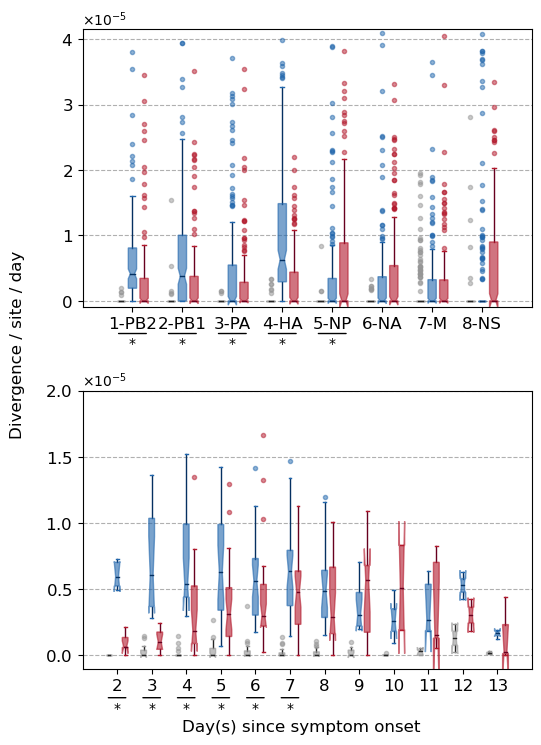

In [26]:
from scipy.stats import wilcoxon

with plt.style.context('default'):
    fig, axes = plt.subplots(2, 1, figsize=(5.8, 8.3))
    color_dict = {0.:{'face':'#2166ac', 'faintline':'#2166ac', 'strongline':'#053061'}, 
                  1.:{'face':'#b2182b', 'faintline':'#b2182b', 'strongline':'#67001f'},
                  -1.:{'face':'#969696', 'faintline':'#969696', 'strongline':'#252525'}}

    annotate_pvalues = {}

    for plot_row, x_variable in enumerate(['Gene', 'Day(s) since symptom onset']):

        ax = axes[plot_row]
        y_max = -1

        syn_and_nonsyn_rate_dist = {}
        for nonsyn in sorted(set(all_r.index.get_level_values(0))):
            sns_all_r = all_r.loc[nonsyn].copy()

            # set x axis variable 
            if x_variable == 'Gene':
                sns_all_r = sns_all_r.set_index([x_variable, 'Patient', 'Day(s) since symptom onset']).sort_index()
            else: 
                sns_all_r = sns_all_r.set_index([x_variable, 'Patient']).sort_index()
            
            if plot_row == 0:
                x_values = sorted(set(sns_all_r.index.get_level_values(0)))
            else: 
                # skip day 1 - only two samples for D1 since symptom onset
                x_values = sorted(set(sns_all_r.index.get_level_values(0)))[1:]

            r_list = []
            for _x, x_val in enumerate(x_values):
                if plot_row == 1: 
                    day_sns_all_r = sns_all_r.loc[x_val]
                    day_r = []
                    for subject_id in set(day_sns_all_r.index):
                        genome_r = (day_sns_all_r.loc[subject_id]['r'].to_numpy()*np.array([influenza_gene_len[gene] for gene in sorted_refnames])).sum()/sum(influenza_gene_len.values())
                        day_r.append(genome_r)
                        #day_r += list(day_sns_all_r.loc[subject_id]['r'])
                    r_list.append(day_r)
                    #print (x_val, len(day_r))
                else: 
                    if isinstance(sns_all_r.loc[x_val, 'r'], pd.Series): 
                        r_list.append(list(sns_all_r.loc[x_val, 'r']))

                        """if _x == 0: 
                            #print (nonsyn, x_val)
                            display (sns_all_r.loc[x_val, 'r'].head())"""
                    else: 
                        r_list.append([sns_all_r.loc[x_val, 'r']])
            syn_and_nonsyn_rate_dist[nonsyn] = r_list
            
            #print (len(x_values), len(r_list))
            """if plot_row == 1 and nonsyn == 1: 
                print (r_list[0])"""
            
            if nonsyn < 0: 
                shift = -.7
            elif nonsyn > 0: 
                shift = .7
            else: 
                shift = 0.

            c = color_dict[nonsyn]
            x_positions = np.arange(0, 3*len(x_values), 3)
            bp = ax.boxplot(r_list, positions=x_positions+shift, notch=True,
                       patch_artist=True,
                       boxprops=dict(facecolor=c['face'], color=c['faintline'], alpha=0.6),
                       capprops=dict(color=c['faintline']),
                       whiskerprops=dict(color=c['strongline']),
                       flierprops=dict(markeredgecolor=c['face'], markerfacecolor=c['face'], marker='.', alpha=0.5),
                       medianprops=dict(color=c['strongline']),)

            max_whisker = max([item.get_ydata()[1] for item in bp['whiskers']])
            if max_whisker > y_max: 
                y_max = max_whisker
        
        # create dataframe of rates
        rate_df = []
        for idx, (r_list1, r_list2) in enumerate(zip(syn_and_nonsyn_rate_dist[0], syn_and_nonsyn_rate_dist[1])):
            r_list3 = syn_and_nonsyn_rate_dist[-1][idx] # stop
            
            med1 = np.median(r_list1)
            med2 = np.median(r_list2)
            med3 = np.median(r_list3)
            
            pval = wilcoxon(r_list1, r_list2).pvalue # perform wilcoxon signed-rank test between syn and nonsyn
            rate_df.append({x_variable:x_values[idx],
                            'med_syn':med1, 'iqr_syn_1':np.quantile(r_list1, 0.25), 'iqr_syn_3':np.quantile(r_list1, 0.75),
                            'min_syn':np.min(r_list1), 'max_syn':np.max(r_list1),
                            'med_nonsyn':med2, 'iqr_nonsyn_1':np.quantile(r_list2, 0.25), 'iqr_nonsyn_3':np.quantile(r_list2, 0.75), 
                            'min_nonsyn':np.min(r_list2), 'max_nonsyn':np.max(r_list2),
                            'pvalue':pval, 
                            'med_stop':med3, 'iqr_stop_1':np.quantile(r_list3, 0.25), 'iqr_stopn_3':np.quantile(r_list3, 0.75), 
                            "min_stop":np.min(r_list3), "max_stop":np.max(r_list3)})
            if pval < 0.05: 
                try: 
                    annotate_pvalues[plot_row].append((x_positions[idx], pval, y_max))
                except: 
                    annotate_pvalues[plot_row] = [(x_positions[idx], pval, y_max)]

        rate_df = pd.DataFrame.from_dict(rate_df)
        rate_df.to_csv('./results/rate_df_%s.csv'%(x_variable), index=False)
        display(rate_df)

        # set ylabel, lim, ticks and scale
        if plot_row == 0:
            ax.set_ylim((-.1e-5,4.15e-5))
        else: 
            ax.set_ylim((-.1e-5,2e-5))
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,10), useMathText=True)

        # set xlabel, lim, ticks and scale
        ax.set_xlim((-3., 3*len(x_values)))
        ax.set_xticks(np.arange(0, 3*len(x_values), 3))
        ax.set_xticklabels(x_values)
        
        # change tick size 
        ax.tick_params(axis='both', which='major', labelsize=12)

        # grid lines 
        ax.grid(axis='y', ls='--', zorder=0)
        ax.set_axisbelow(True)
        
        if plot_row == 1:
            ax.set_xlabel(x_variable, fontsize=12)
            # get a tick and will position things next to the last one
            ticklab = ax.xaxis.get_ticklabels()[0]
            trans = ticklab.get_transform()
            ax.xaxis.set_label_coords(16, -0.15, transform=trans)

    for plot_idx in annotate_pvalues.keys(): 
        ax = axes[plot_idx]
        for (x_pos, pval, y_max) in annotate_pvalues[plot_idx]:
            if plot_idx == 0:
                y_pos = -0.5e-5
            else: 
                y_pos = -0.32e-5
            ######### annotating the x axis   #########
            ax.annotate('', xy=(x_pos-1., y_pos),
                        xytext=(x_pos+1., y_pos),
                        arrowprops=dict(arrowstyle='-',facecolor='red'),          
                        annotation_clip=False)  
            
            ax.annotate("*",
                        xy=(x_pos-1., y_pos-.15e-5 if plot_idx == 0 else y_pos-.08e-5),
                        xytext=(x_pos, y_pos-.15e-5 if plot_idx == 0 else y_pos-.08e-5),
                        ha='center', va='center',
                        annotation_clip=False)

    fig.subplots_adjust(hspace=0.3)

    # y-axis label 
    fig.text(0., 0.5, 'Divergence / site / day', va='center', 
             fontsize=label_size, rotation=90)

    """# legend 
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Synonymous',
                              markerfacecolor='#2b83ba', markersize=12), 
                       Line2D([0], [0], marker='o', color='w', label='Nonsynonymous',
                              markerfacecolor='#d7191c', markersize=12)]
    #fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.93, 0.45), fontsize=10)"""
    plt.savefig('./results/figures/evolutionary_rate.pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()


/Users/alvin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/alvin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/alvin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/alvin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/alvin/opt/anaconda3/lib/python3.7/s

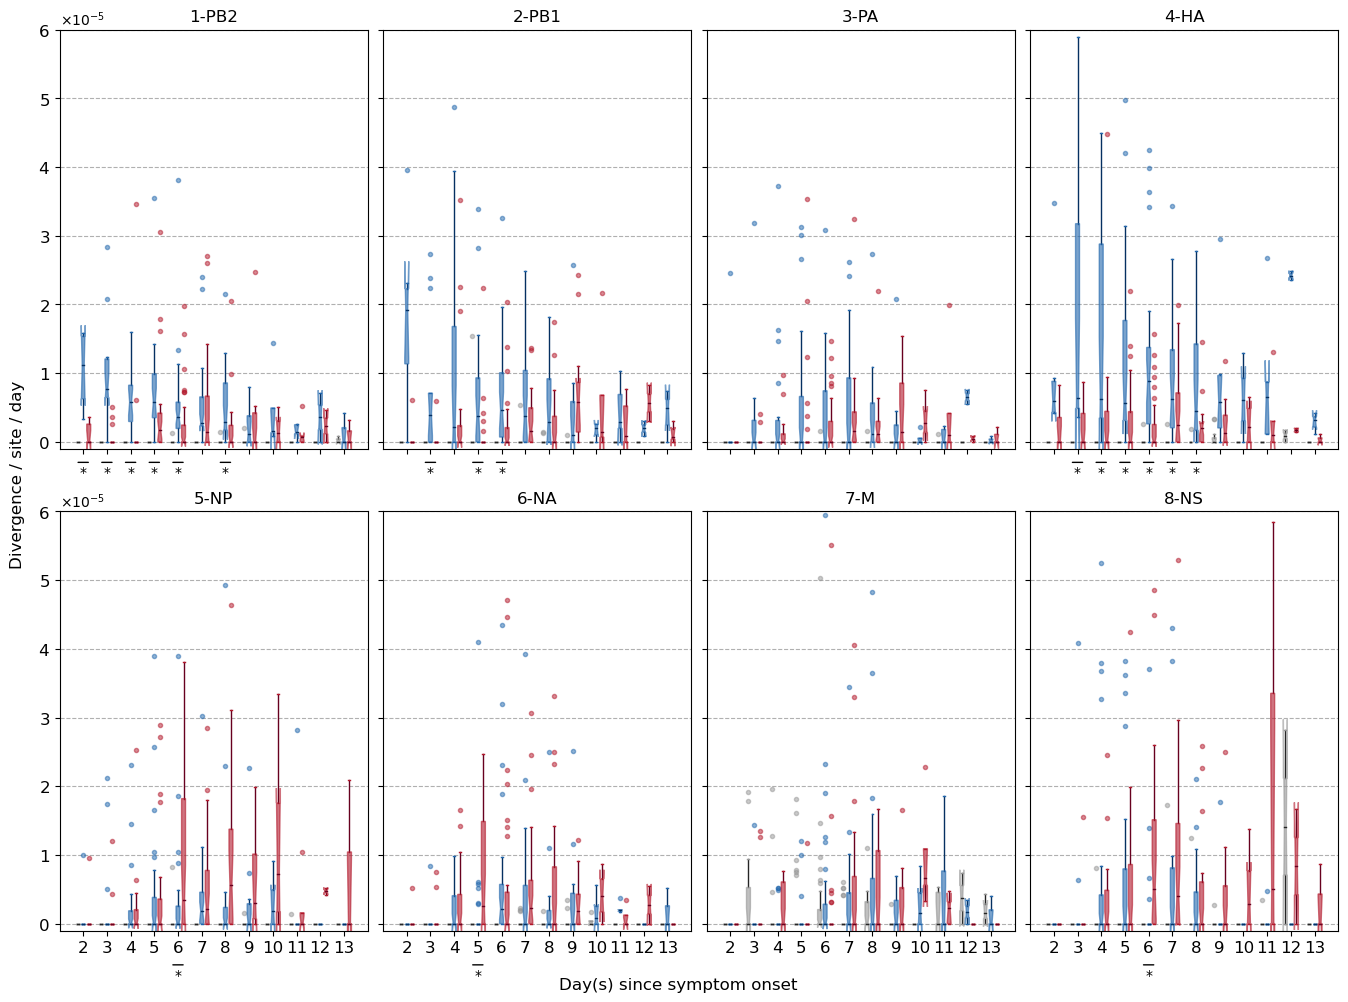

In [27]:
with plt.style.context('default'):
    fig, axes = plt.subplots(2, 4, figsize=(16.5, 11.7), sharex=True, sharey=True)
    color_dict = {0.:{'face':'#2166ac', 'faintline':'#2166ac', 'strongline':'#053061'}, 
                  1.:{'face':'#b2182b', 'faintline':'#b2182b', 'strongline':'#67001f'},
                  -1.:{'face':'#969696', 'faintline':'#969696', 'strongline':'#252525'}}

    annotate_pvalues = {}
    x_variable = 'Day(s) since symptom onset'
    for gidx, gene in enumerate(sorted_refnames):
        if gidx < 4: 
            plot_row = 0
        else: 
            plot_row = 1
        plot_col = gidx%4
        
        ax = axes[(plot_row, plot_col)]
        y_max = -1

        syn_and_nonsyn_rate_dist = {}
        for nonsyn in sorted(set(all_r.index.get_level_values(0))):
            sns_all_r = all_r.loc[nonsyn].copy()
            
            sns_all_r = sns_all_r.set_index([x_variable, 'Patient', 'Gene']).sort_index()
            sns_all_r = sns_all_r.xs(gene, level=2)
            
            # start from day 2 onwards
            x_values = sorted(set(sns_all_r.index.get_level_values(0)))[1:]

            r_list = []
            for _x, x_val in enumerate(x_values):
                if isinstance(sns_all_r.loc[x_val, 'r'], pd.Series): 
                    r_list.append(list(sns_all_r.loc[x_val, 'r']))

                    """if _x == 0: 
                        print (nonsyn, x_val)
                        display (sns_all_r.loc[x_val, 'r'].head())"""

                else: 
                    r_list.append([sns_all_r.loc[x_val, 'r']])
            syn_and_nonsyn_rate_dist[nonsyn] = r_list

            if nonsyn > 0: 
                shift = .7
            elif nonsyn < 0: 
                shift = -.7
            else: 
                shift = 0.

            c = color_dict[nonsyn]
            x_positions = np.arange(0, 3*len(x_values), 3)
            bp = ax.boxplot(r_list, positions=x_positions+shift, notch=True,
                       patch_artist=True,
                       boxprops=dict(facecolor=c['face'], color=c['faintline'], alpha=0.6),
                       capprops=dict(color=c['faintline']),
                       whiskerprops=dict(color=c['strongline']),
                       flierprops=dict(markeredgecolor=c['face'], markerfacecolor=c['face'], marker='.', alpha=0.5),
                       medianprops=dict(color=c['strongline']),)

            max_whisker = max([item.get_ydata()[1] for item in bp['whiskers']])
            if max_whisker > y_max: 
                y_max = max_whisker
        
        # create dataframe of rates
        rate_df = []
        for idx, (r_list1, r_list2) in enumerate(zip(syn_and_nonsyn_rate_dist[0], syn_and_nonsyn_rate_dist[1])):
            r_list3 = syn_and_nonsyn_rate_dist[-1][idx] # stop
            
            med1 = np.median(r_list1)
            med2 = np.median(r_list2)
            med3 = np.median(r_list3)
            
            try: 
                #if len(r_list1) >= 10: 
                pval = wilcoxon(r_list1, r_list2).pvalue # perform wilcoxon signed-rank test between syn and nonsyn
            except: 
                pval = None
            rate_df.append({x_variable:x_values[idx], 'med_syn':med1, 'mad_syn':np.median([abs(r-med1) for r in r_list1]),
                            'min_syn':np.min(r_list1), 'max_syn':np.max(r_list1),
                            'med_nonsyn':med2, 'mad_nonsyn':np.median([abs(r-med2) for r in r_list2]),
                            'min_nonsyn':np.min(r_list2), 'max_nonsyn':np.max(r_list2),
                            'pvalue':pval, 
                            'med_stop':med3, "mad_stop":np.median([abs(r-med3) for r in r_list3]), 
                            "min_stop":np.min(r_list3), "max_stop":np.max(r_list3)})
            
            if pval != None and pval < 0.05: 
                try: 
                    annotate_pvalues[(plot_row, plot_col)].append((x_positions[idx], pval, y_max))
                except: 
                    annotate_pvalues[(plot_row, plot_col)] = [(x_positions[idx], pval, y_max)]
        
        rate_df = pd.DataFrame.from_dict(rate_df)
        rate_df.to_csv('./results/rate_gene_df_%s.csv'%(x_variable), index=False)
        #display(rate_df)

        # set ylabel, lim, ticks and scale
        ax.set_ylim((-.1e-5, 6e-5))
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,10), useMathText=True)

        # set xlabel, lim, ticks and scale
        ax.set_xlim((-3., 3*len(x_values)))
        ax.set_xticks(np.arange(0, 3*len(x_values), 3))
        ax.set_xticklabels(x_values)
        
        ax.set_title(gene)
        
        # change tick size 
        ax.tick_params(axis='both', which='major', labelsize=12)

        # grid lines 
        ax.grid(axis='y', ls='--', zorder=0)
        ax.set_axisbelow(True)
        
        if plot_row == 1:
            # get a tick and will position things next to the last one
            ticklab = ax.xaxis.get_ticklabels()[0]
            trans = ticklab.get_transform()
            ax.xaxis.set_label_coords(16, -0.15, transform=trans)

    for (plot_row, plot_col) in annotate_pvalues.keys(): 
        ax = axes[(plot_row, plot_col)]
        for (x_pos, pval, y_max) in annotate_pvalues[(plot_row, plot_col)]:
            if plot_row == 1: 
                y_pos = -.6e-5
            else: 
                y_pos = -.3e-5
            ######### annotating the x axis   #########
            ax.annotate('', xy=(x_pos-1., y_pos),
                        xytext=(x_pos+1., y_pos),
                        arrowprops=dict(arrowstyle='-',facecolor='red'),          
                        annotation_clip=False)  
            
            ax.annotate("*",
                        xy=(x_pos-1., y_pos-.15e-5),
                        xytext=(x_pos, y_pos-.15e-5),
                        ha='center', va='center',
                        annotation_clip=False)

    fig.subplots_adjust(hspace=0.3)

    # y-axis label 
    fig.text(0.095, 0.5, 'Divergence / site / day', va='center', 
             fontsize=label_size, rotation=90)
    # x-axis label
    fig.text(0.5, 0.06, x_variable, ha='center', 
             fontsize=label_size)

    # legend 
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Synonymous',
                              markerfacecolor='#2b83ba', markersize=12), 
                       Line2D([0], [0], marker='o', color='w', label='Nonsynonymous',
                              markerfacecolor='#d7191c', markersize=12)]
    #fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.93, 0.45), fontsize=10)
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    plt.savefig('./results/figures/evolutionary_rate_gene.pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()
